In [1]:
import pandas as pd
import seaborn as sns
import statsmodels.api as sm

import statsmodels.tsa.vector_ar.vecm as vecm


import numpy as np
from statsmodels.tsa.api import VAR


from statsmodels.tsa.arima.model import ARIMA

import matplotlib.pyplot as plt
from matplotlib import font_manager

from statsmodels.tsa.vector_ar.vecm import coint_johansen, VECM
from statsmodels.tsa.stattools import adfuller, kpss

plt.rcParams['font.sans-serif'] = ['Arial'] 

In [2]:
file_path = '/Users/apple/Desktop/industries-stock/CET.xlsx'
carbon_market = pd.read_excel(file_path, names=['TradingDate', 'CityName', 'TradingType', 'AvgPrice', 'Volume', 'Amount'], skiprows=1)
carbon_market['TradingDate'] = pd.to_datetime(carbon_market['TradingDate'])


file_paths = {
    'FD': '/Users/apple/Desktop/industries-stock/FD.xlsx',
    'HK': '/Users/apple/Desktop/industries-stock/航空铁路等运输制造.xlsx',
    'HG': '/Users/apple/Desktop/industries-stock/化工.xlsx',
    'JS': '/Users/apple/Desktop/industries-stock/金属制造（钢铁）.xlsx',
    'SH': '/Users/apple/Desktop/industries-stock/石油加工、炼焦和核燃料加工业.xlsx',
    'YSJS': '/Users/apple/Desktop/industries-stock/有色金属.xlsx',
    'ZZ': '/Users/apple/Desktop/industries-stock/造纸.xlsx'
}

industry_data = {}

# Daily rate of return (Ratio)
for key, file_path in file_paths.items():
    df = pd.read_excel(file_path)
    df['TradingDate'] = pd.to_datetime(df['TradingDate'])
    df = df.sort_values('TradingDate')
    df['Ratio'] = df['ClosePrice'].pct_change() * 100  
    industry_data[key] = df   


In [3]:
# Choosing time period
start_date = pd.to_datetime('2020-01-01')
end_date = pd.to_datetime('2024-06-04')

# clean the carbon market data
carbon_market = carbon_market[(carbon_market['TradingDate'] >= start_date) & (carbon_market['TradingDate'] <= end_date)]


    
# Align industry data and handle blank dates
for key in industry_data:
    df = industry_data[key]
    df = df[(df['TradingDate'] >= start_date) & (df['TradingDate'] <= end_date)]
    df = df.set_index('TradingDate').reindex(pd.date_range(start_date, end_date)).reset_index()
    df.rename(columns={'index': 'TradingDate'}, inplace=True)
    
    # test missing value ratio
    missing_ratio = df.isna().mean()
    
    # apply suitable methods
    if missing_ratio.mean() < 0.1: 
        df = df.interpolate(method='linear').fillna(method='bfill').fillna(method='ffill')
    else:  
        df = df.dropna()
    
    industry_data[key] = df
    

In [4]:
#information summary
carbon_market_summary = carbon_market.describe()
print("Carbon Market Data Summary:")
print(carbon_market_summary)


Carbon Market Data Summary:
                         TradingDate     AvgPrice        Volume        Amount
count                           6580  6551.000000  6.580000e+03  6.248000e+03
mean   2021-12-21 17:16:00.729483520    42.208942  2.540769e+04  1.118353e+06
min              2020-01-02 00:00:00     3.510000  1.000000e+00  3.890000e+00
25%              2020-11-18 00:00:00    25.235000  3.000000e+01  8.566375e+02
50%              2021-10-26 00:00:00    38.530000  2.522000e+03  1.043525e+05
75%              2022-12-23 00:00:00    58.900000  1.537550e+04  7.118925e+05
max              2024-06-04 00:00:00   149.640000  2.351982e+06  8.556538e+07
std                              NaN    25.902178  8.116562e+04  3.358201e+06


In [5]:
print("Industry Data Summary:")
for key, df in industry_data.items():
    print(f"\nSummary for {key}:")
    industry_summary = df.describe()
    print(industry_summary)
 

Industry Data Summary:

Summary for FD:
                         TradingDate  ClosePrice       Ratio
count                            966  966.000000  966.000000
mean   2022-02-27 12:46:12.670807296    7.135724    0.046105
min              2020-01-02 00:00:00    5.208000   -8.079784
25%              2021-02-04 06:00:00    6.119000   -0.858252
50%              2022-02-09 12:00:00    7.377500    0.059056
75%              2023-02-23 18:00:00    7.962250    1.006257
max              2024-06-04 00:00:00    9.475000    8.242385
std                              NaN    1.058759    1.711911

Summary for HK:
                         TradingDate  ClosePrice       Ratio
count                            957  957.000000  957.000000
mean   2022-02-28 13:47:35.172413696   21.531727    0.052118
min              2020-01-02 00:00:00   13.208000  -10.859365
25%              2021-01-14 00:00:00   19.971000   -1.076681
50%              2022-02-16 00:00:00   21.965000    0.072884
75%              2023-04-20 

In [6]:
industry_data['HG'].tail(20)

TradingDate    PlateTitle  ClosePrice     Ratio
1589  2024-05-08  化学原料和化学制品制造业      16.456 -0.986763
1590  2024-05-09  化学原料和化学制品制造业      16.587  0.796062
1591  2024-05-10  化学原料和化学制品制造业      16.272 -1.899078
1594  2024-05-13  化学原料和化学制品制造业      16.011 -1.603982
1595  2024-05-14  化学原料和化学制品制造业      16.068  0.356005
1596  2024-05-15  化学原料和化学制品制造业      16.011 -0.354742
1597  2024-05-16  化学原料和化学制品制造业      15.985 -0.162388
1598  2024-05-17  化学原料和化学制品制造业      16.082  0.606819
1601  2024-05-20  化学原料和化学制品制造业      16.214  0.820793
1602  2024-05-21  化学原料和化学制品制造业      15.961 -1.560380
1603  2024-05-22  化学原料和化学制品制造业      15.980  0.119040
1604  2024-05-23  化学原料和化学制品制造业      15.618 -2.265332
1605  2024-05-24  化学原料和化学制品制造业      15.421 -1.261365
1608  2024-05-27  化学原料和化学制品制造业      15.601  1.167239
1609  2024-05-28  化学原料和化学制品制造业      15.384 -1.390936
1610  2024-05-29  化学原料和化学制品制造业      15.493  0.708528
1611  2024-05-30  化学原料和化学制品制造业      15.433 -0.387272
1612  2024-05-31  化学原料和化学制品制造业      15.333 -0.647962
1615  2024-06-03  化学原料和化学制品制造业      15.044 -1.884824
1616  2024-06-04  化学原料和化学制品制造业      14.977 -0.445360

In [7]:
# Daily carbon price with different cities
carbon_market['TradingDate'] = pd.to_datetime(carbon_market['TradingDate'])

city_daily_avg = carbon_market.groupby(['CityName', 'TradingDate'])['AvgPrice'].mean().reset_index()

cities = city_daily_avg['CityName'].unique()

# Grouping the filtered data by 'CityName' and 'TradingDate' and calculating the mean of 'AvgPrice'
city_daily_avg = carbon_market.groupby(['CityName', 'TradingDate'])['AvgPrice'].mean().reset_index()
cities = city_daily_avg['CityName'].unique()




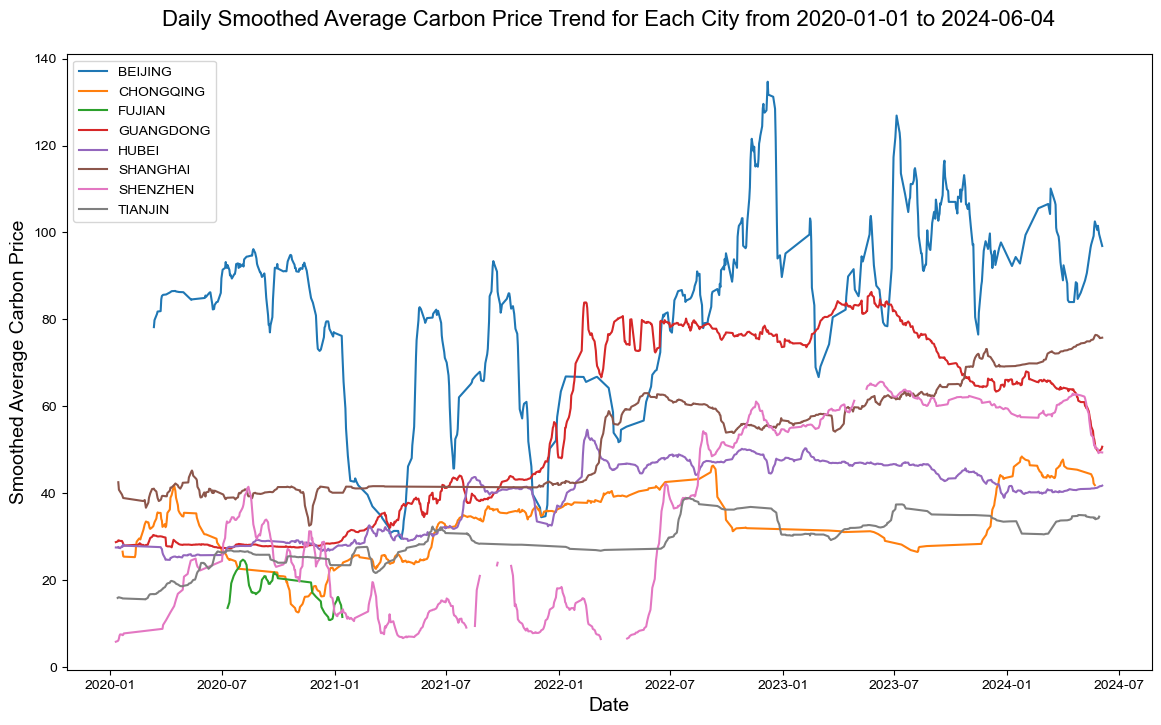

In [26]:
# using smoothed average price
window_size = 7
city_daily_avg['SmoothedAvgPrice'] = city_daily_avg.groupby('CityName')['AvgPrice'].transform(lambda x: x.rolling(window=window_size).mean())


cities = city_daily_avg['CityName'].unique()

plt.figure(figsize=(14, 8))

for city in cities:
    city_data = city_daily_avg[city_daily_avg['CityName'] == city]
    plt.plot(city_data['TradingDate'], city_data['SmoothedAvgPrice'], label=city)

plt.xlabel('Date', fontsize=14)
plt.ylabel('Smoothed Average Carbon Price', fontsize=14)
plt.title('Daily Smoothed Average Carbon Price Trend for Each City from 2020-01-01 to 2024-06-04', fontsize=16, pad=20)
plt.legend()
plt.show()


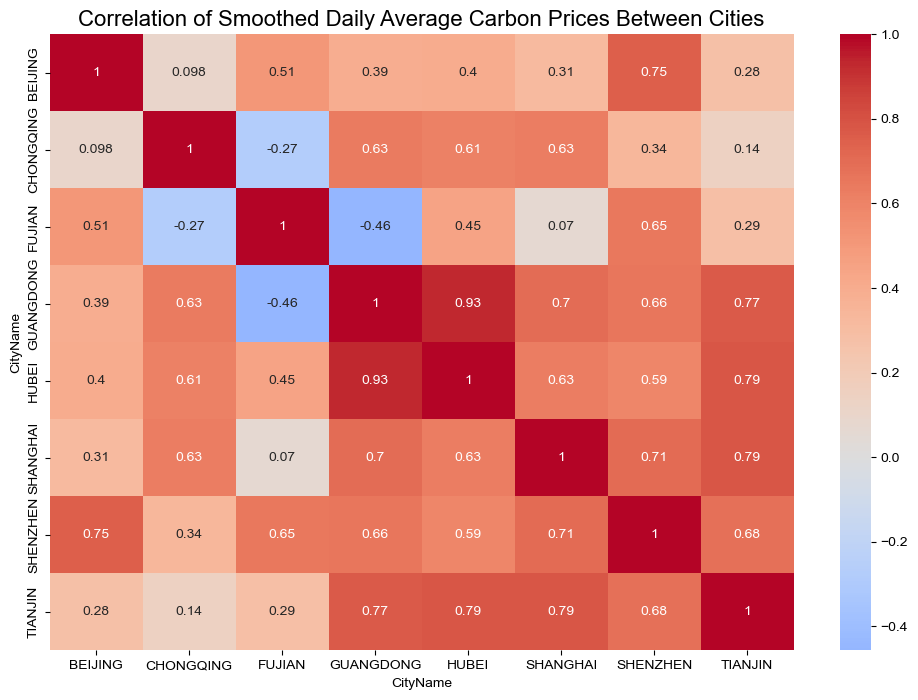

In [24]:
pivot_df = city_daily_avg.pivot(index='TradingDate', columns='CityName', values='SmoothedAvgPrice')

corr_matrix = pivot_df.corr()

plt.figure(figsize=(12, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', center=0)
plt.title('Correlation of Smoothed Daily Average Carbon Prices Between Cities', fontsize=16)
plt.show()

In [16]:
# Beijing data
beijing_data = city_daily_avg[city_daily_avg['CityName'] == 'BEIJING']

# Shenzhen data
shenzhen_data = city_daily_avg[city_daily_avg['CityName'] == 'SHENZHEN']


In [17]:
#remove data from Beijing,Shenzhen and Fujian
cities_to_remove = ['BEIJING', 'SHENZHEN', 'FUJIAN']
filtered_data = city_daily_avg[~city_daily_avg['CityName'].isin(cities_to_remove)]


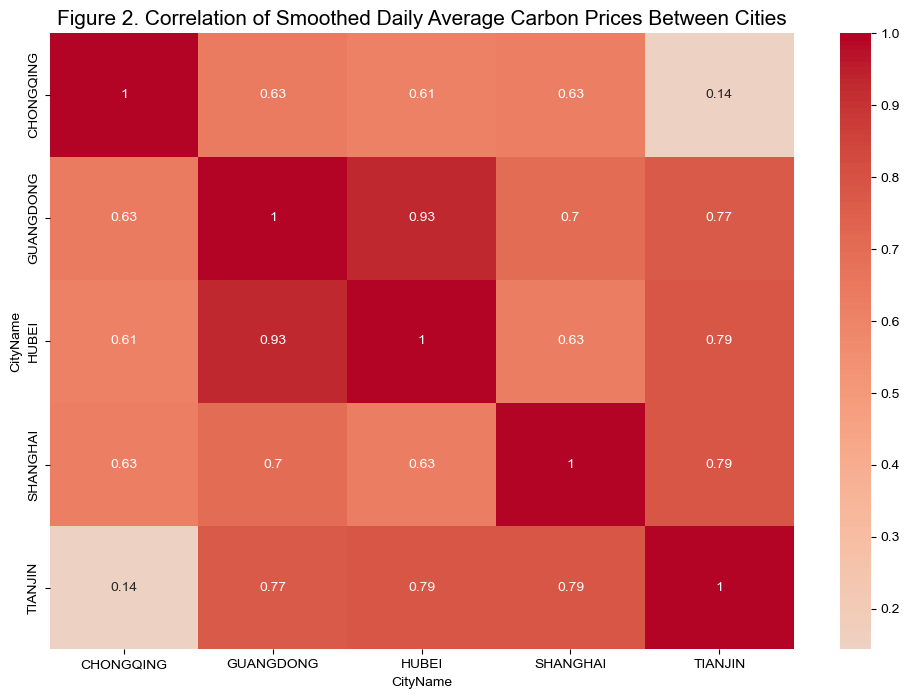

In [21]:
pivot_df = filtered_data.pivot(index='TradingDate', columns='CityName', values='SmoothedAvgPrice')

corr_matrix = pivot_df.corr()

plt.figure(figsize=(12, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', center=0)
plt.title('Figure 2. Correlation of Smoothed Daily Average Carbon Prices Between Cities', fontsize=15)
plt.show()


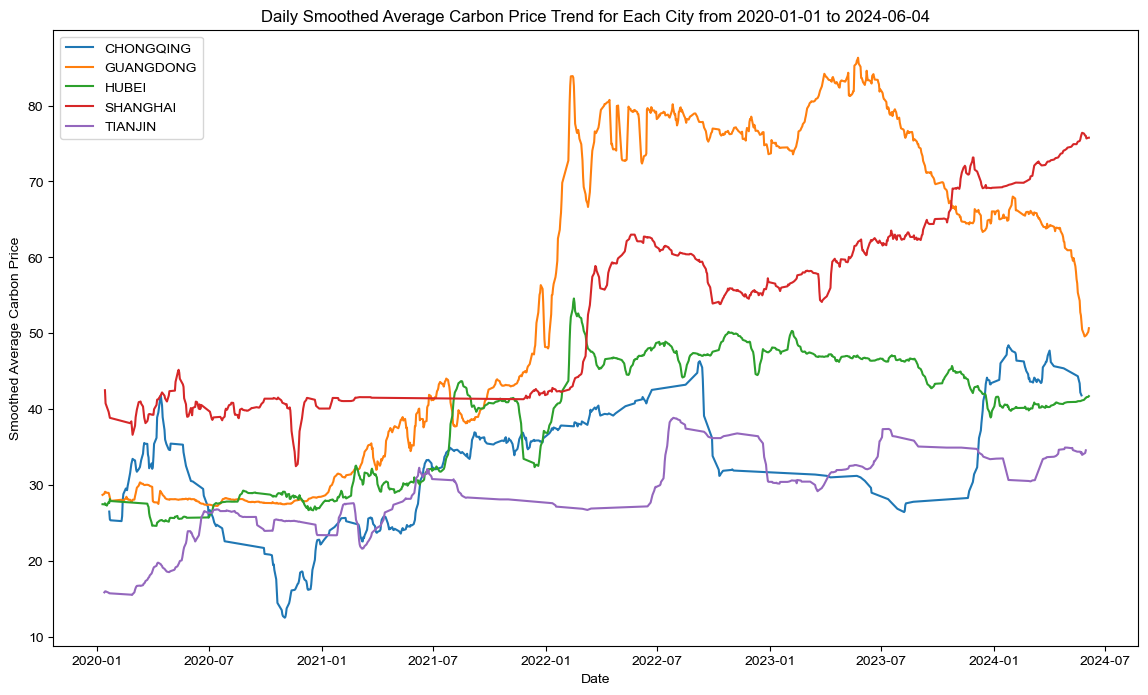

In [13]:
# price trend for each city
cities = filtered_data['CityName'].unique()

plt.figure(figsize=(14, 8))

for city in cities:
    city_data = filtered_data[filtered_data['CityName'] == city]
    plt.plot(city_data['TradingDate'], city_data['SmoothedAvgPrice'], label=city)

plt.xlabel('Date')
plt.ylabel('Smoothed Average Carbon Price')
plt.title('Daily Smoothed Average Carbon Price Trend for Each City from 2020-01-01 to 2024-06-04')
plt.legend()
plt.show()

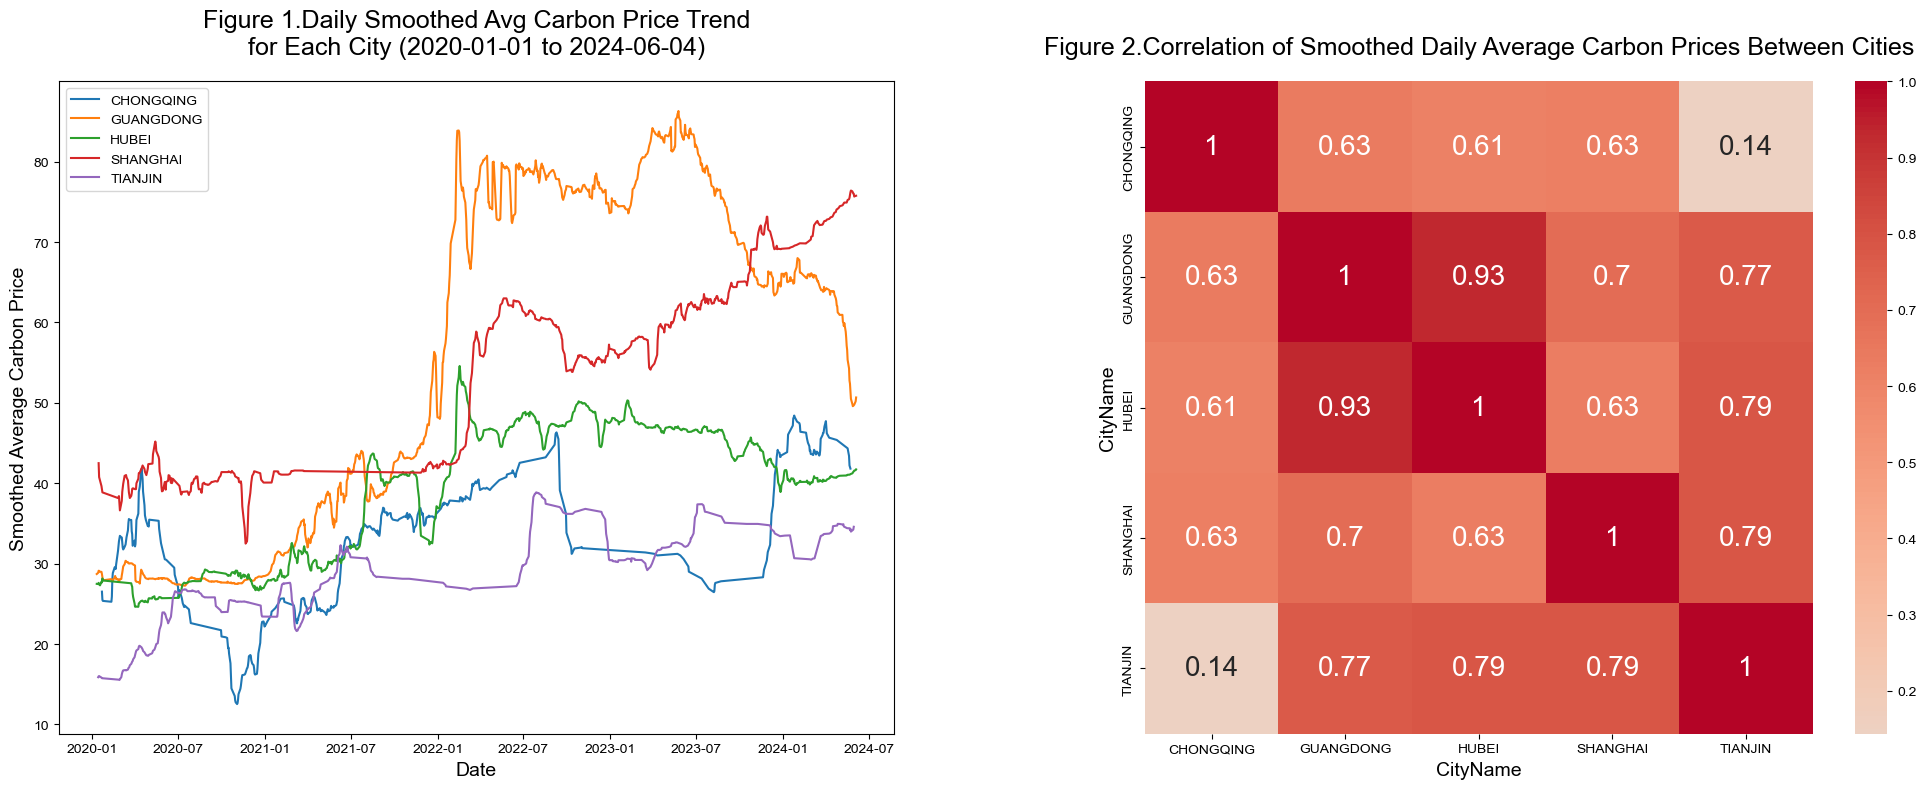

In [62]:

cities = filtered_data['CityName'].unique()

# Create a subplot with 1 row and 2 columns
fig, ax = plt.subplots(1, 2, figsize=(20, 8))

# Plot the first figure on the first axis
for city in cities:
    city_data = filtered_data[filtered_data['CityName'] == city]
    ax[0].plot(city_data['TradingDate'], city_data['SmoothedAvgPrice'], label=city)


ax[0].set_xlabel('Date', fontsize=14)
ax[0].set_ylabel('Smoothed Average Carbon Price', fontsize=14)
ax[0].set_title('Figure 1.Daily Smoothed Avg Carbon Price Trend\nfor Each City (2020-01-01 to 2024-06-04)', fontsize=18, pad=20)
ax[0].legend()

pivot_df = filtered_data.pivot(index='TradingDate', columns='CityName', values='SmoothedAvgPrice')

corr_matrix = pivot_df.corr()

# Plot the second figure on the second axis
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', center=0, ax=ax[1], annot_kws={"size": 20})
ax[1].set_xlabel('CityName', fontsize=14)
ax[1].set_ylabel('CityName', fontsize=14)
ax[1].set_title('Figure 2.Correlation of Smoothed Daily Average Carbon Prices Between Cities', fontsize=18, pad=20)

# Adjust layout and save the combined figure
plt.tight_layout()

plt.subplots_adjust(wspace=0.3)
plt.savefig('/Users/apple/Desktop/combined_figure1_figure2.png') 
plt.show()

In [63]:

# Daily carbon price
daily_avg = filtered_data.groupby('TradingDate')['AvgPrice'].mean().reset_index()
daily_avg = daily_avg.rename(columns={'AvgPrice': 'DAvgPrice'})

print(daily_avg)

daily_avg.to_excel('Daily_Average_Carbon_Price.xlsx', index=False)

     TradingDate  DAvgPrice
0     2020-01-02  30.082500
1     2020-01-03  29.215000
2     2020-01-06  24.243333
3     2020-01-07  28.285000
4     2020-01-08  26.985000
...          ...        ...
1077  2024-05-29  51.042500
1078  2024-05-30  50.862500
1079  2024-05-31  56.113333
1080  2024-06-03  57.106667
1081  2024-06-04  56.716667

[1082 rows x 2 columns]


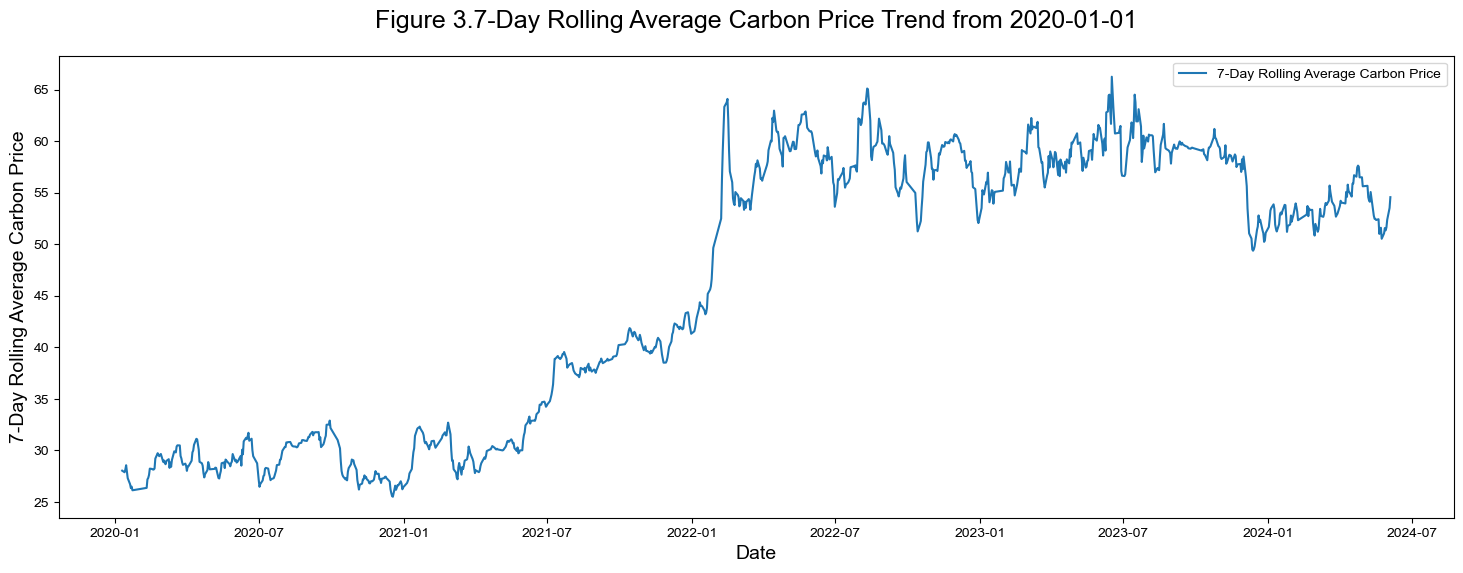

In [64]:
daily_avg['RollingAvgPrice'] = daily_avg['DAvgPrice'].rolling(window=7).mean()

plt.figure(figsize=(18, 6))
plt.plot(daily_avg['TradingDate'], daily_avg['RollingAvgPrice'], label='7-Day Rolling Average Carbon Price')

plt.xlabel('Date',fontsize = 14)
plt.ylabel('7-Day Rolling Average Carbon Price',fontsize = 14)
plt.title('Figure 3.7-Day Rolling Average Carbon Price Trend from 2020-01-01', fontsize=18, pad=20)
plt.legend()

plt.savefig('/Users/apple/Desktop/Figure3.png')  # Save in the current directory
plt.show()
plt.close()

In [43]:
daily_avg.tail(20)

TradingDate  DAvgPrice  RollingAvgPrice
1062  2024-05-08  52.195000        54.262976
1063  2024-05-09  52.070000        54.140119
1064  2024-05-10  58.846667        55.085714
1065  2024-05-13  47.300000        53.404762
1066  2024-05-14  48.520000        52.795833
1067  2024-05-15  56.870000        52.487738
1068  2024-05-16  51.542500        52.477738
1069  2024-05-17  51.435000        52.369167
1070  2024-05-20  52.632500        52.449524
1071  2024-05-21  48.874000        51.024857
1072  2024-05-22  50.890000        51.537714
1073  2024-05-23  49.086000        51.618571
1074  2024-05-24  49.385000        50.549286
1075  2024-05-27  55.176667        51.068452
1076  2024-05-28  55.086667        51.590119
1077  2024-05-29  51.042500        51.362976
1078  2024-05-30  50.862500        51.647048
1079  2024-05-31  56.113333        52.393238
1080  2024-06-03  57.106667        53.539048
1081  2024-06-04  56.716667        54.586429

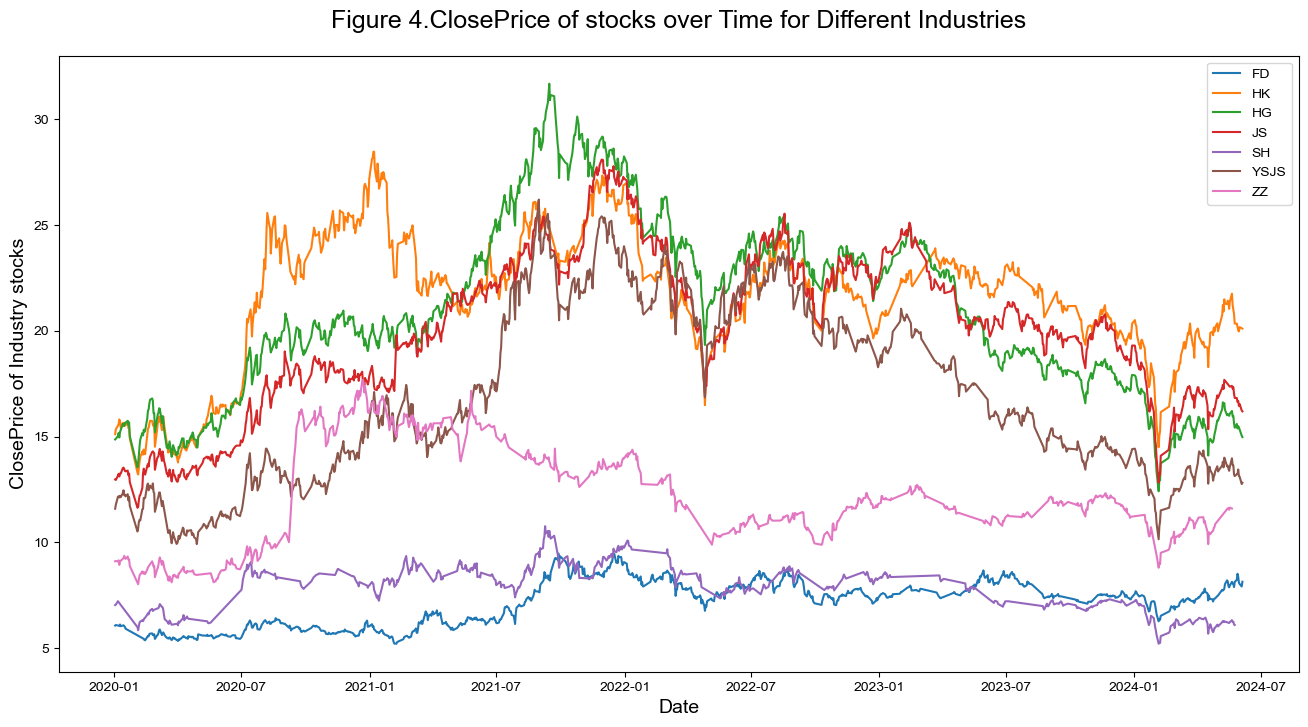

In [44]:
# index close price trends

plt.figure(figsize=(16, 8))

for key, df in industry_data.items():
    sns.lineplot(x='TradingDate', y='ClosePrice', data=df, label=key)

plt.xlabel('Date',fontsize=14)
plt.ylabel('ClosePrice of Industry stocks',fontsize=14)
plt.title('Figure 4.ClosePrice of stocks over Time for Different Industries',fontsize=18, pad=20)
plt.legend()
plt.savefig('/Users/apple/Desktop/Figure4.png')  # Save in the current directory
plt.show()
plt.close()

In [18]:
#Firtly divieded according to the figure,then change by trying for the most suitable

In [48]:
grouped_industries = {
    'Group_1': ['HG', 'JS', 'YSJS'],
    'Group_2': ['FD'],
    'Group_3': ['ZZ', 'HK', 'SH'],
}

print("NEW GROUPS：")
for group, industries in grouped_industries.items():
    print(f"{group}: {', '.join(industries)}")

NEW GROUPS：
Group_1: HG, JS, YSJS
Group_2: FD
Group_3: ZZ, HK, SH


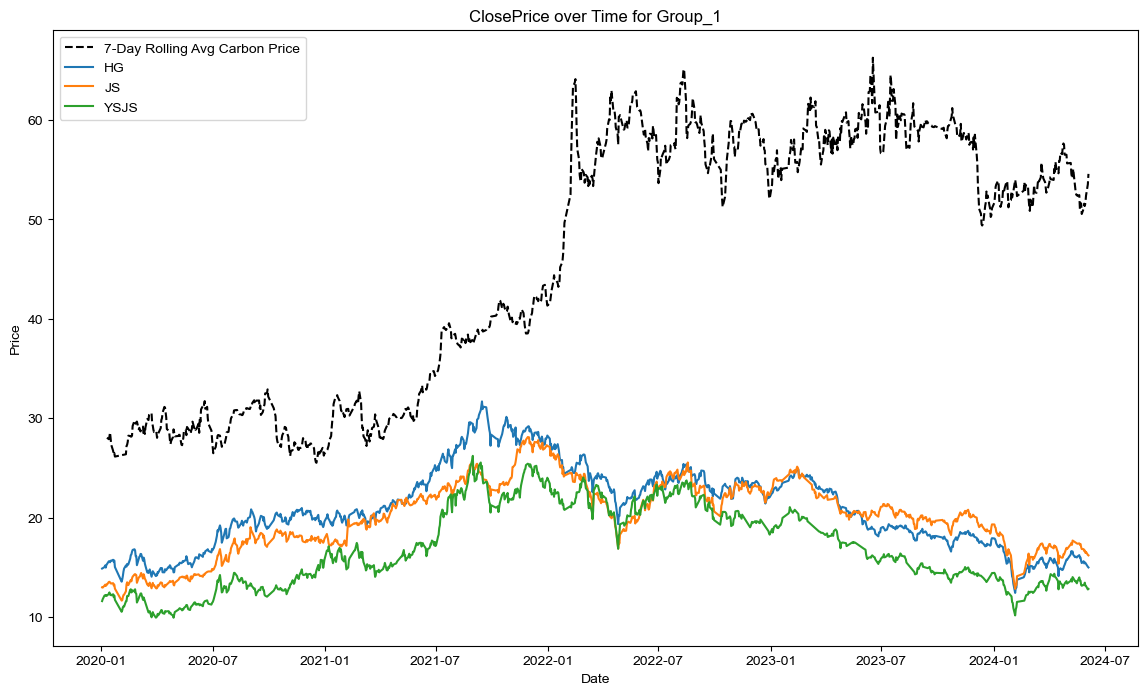

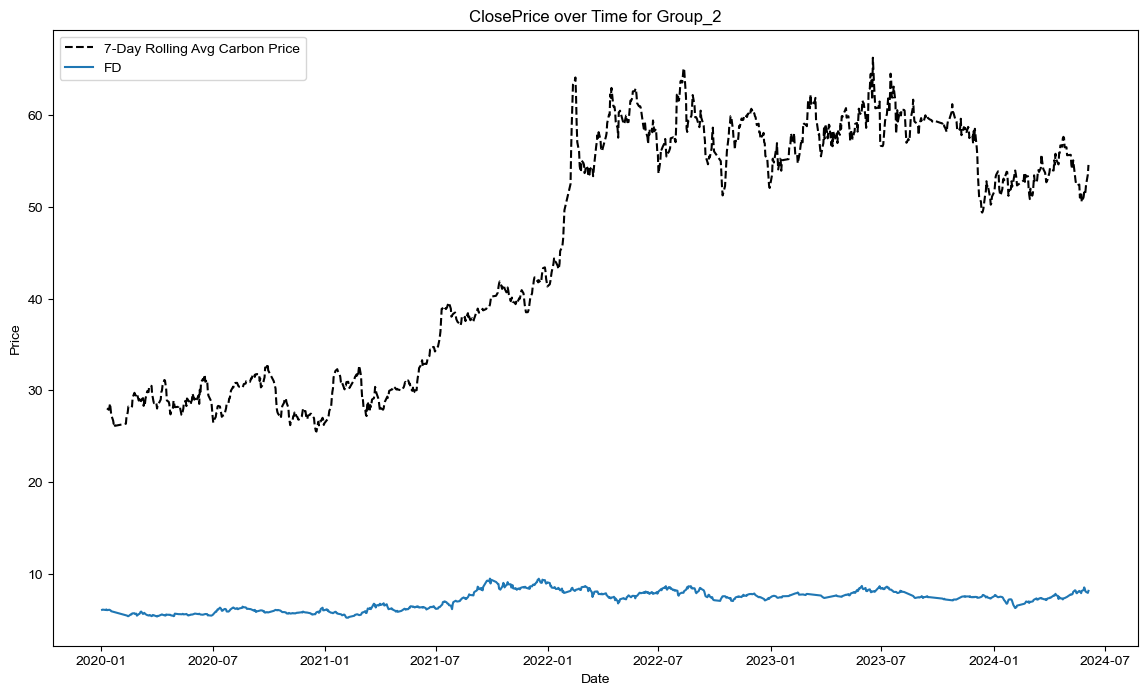

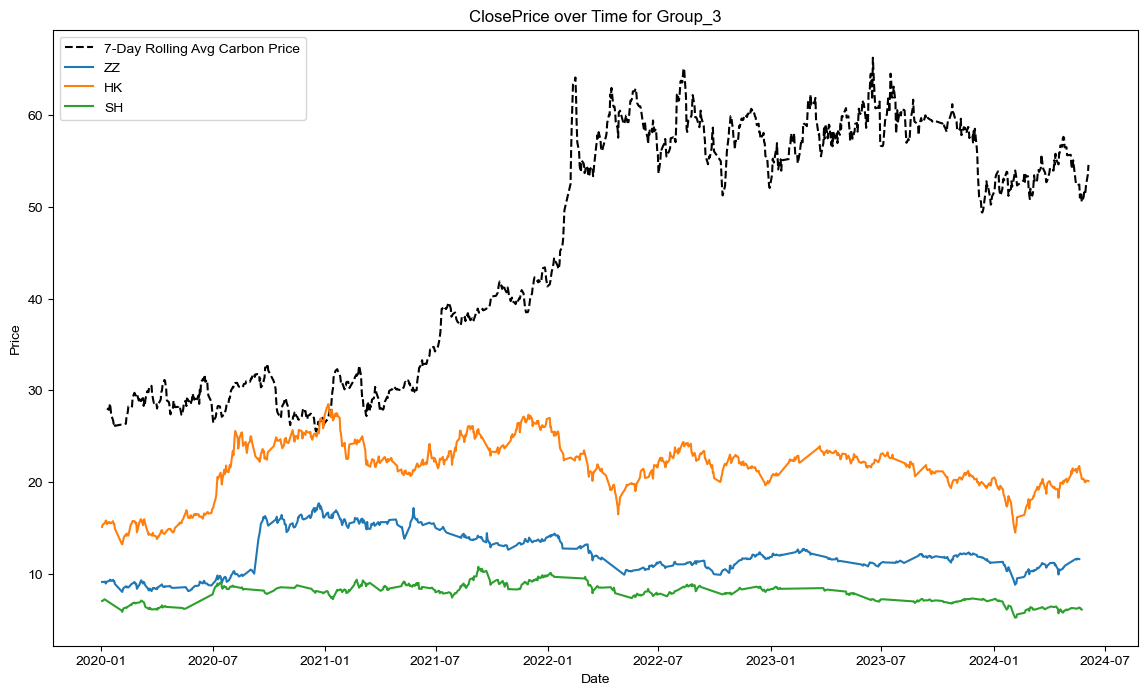

In [49]:
carbon_market['TradingDate'] = pd.to_datetime(carbon_market['TradingDate'])
daily_avg['TradingDate'] = pd.to_datetime(daily_avg['TradingDate'])


# merge 
carbon_market = carbon_market[['TradingDate', 'AvgPrice']]
daily_avg = daily_avg[['TradingDate', 'RollingAvgPrice']]

#plot for each group
for group_idx, (group, industries) in enumerate(grouped_industries.items()):
    plt.figure(figsize=(14, 8))
    
    sns.lineplot(x='TradingDate', y='RollingAvgPrice', data=daily_avg, label='7-Day Rolling Avg Carbon Price', color='black', linestyle='--')
    
    for industry in industries:
        df = industry_data[industry]
        df['TradingDate'] = pd.to_datetime(df['TradingDate'])
        sns.lineplot(x='TradingDate', y='ClosePrice', data=df, label=industry)
    
    plt.xlabel('Date')
    plt.ylabel('Price')
    plt.title(f'ClosePrice over Time for {group}')
    plt.legend()
    plt.show()


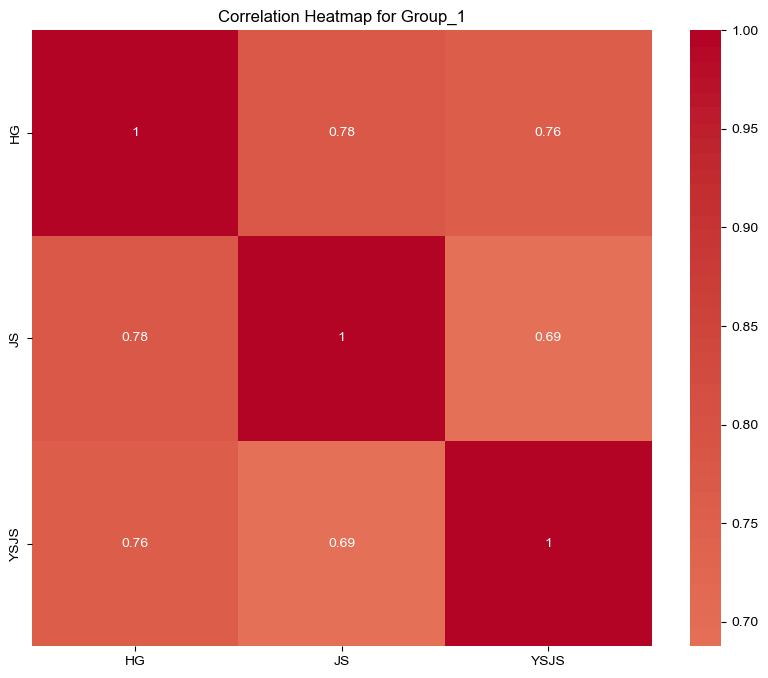

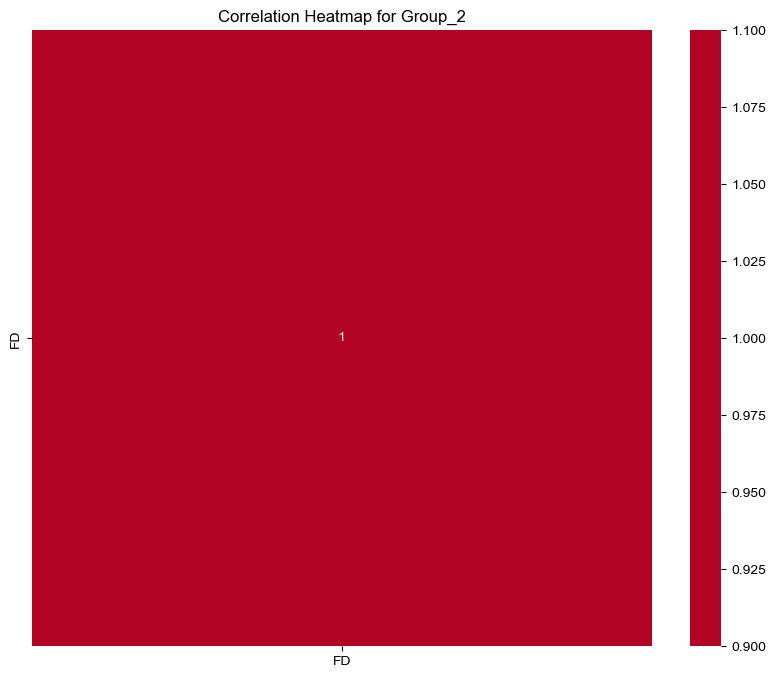

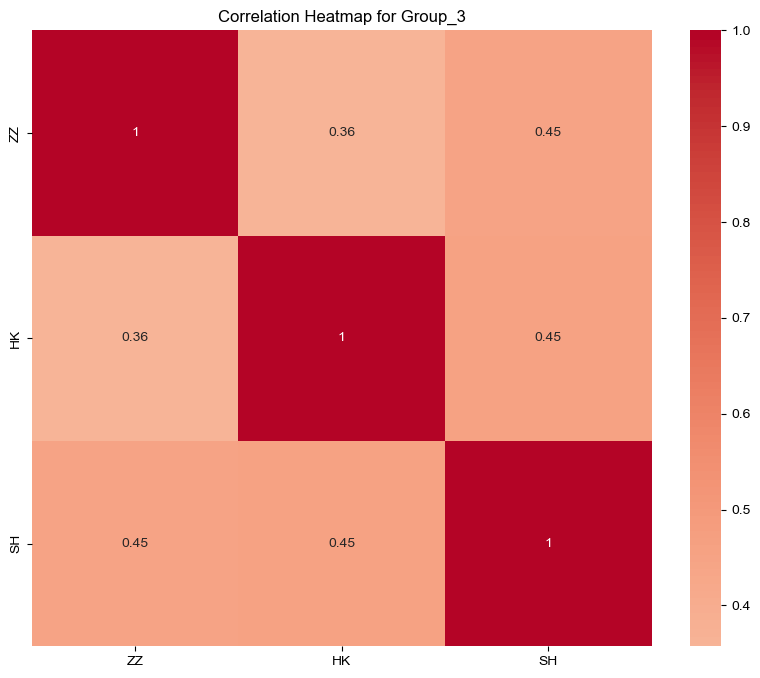

In [50]:
#heat correlation for each group
for group_idx, (group, industries) in enumerate(grouped_industries.items()):
    plt.figure(figsize=(10, 8))

    merged_df = pd.DataFrame()
    for industry in industries:
        df = industry_data[industry][['TradingDate', 'Ratio']].copy()
        df.set_index('TradingDate', inplace=True)
        df.rename(columns={'Ratio': industry}, inplace=True)
        if merged_df.empty:
            merged_df = df
        else:
            merged_df = merged_df.join(df, how='outer')

    correlation_matrix = merged_df.corr()
    
  
    sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0)
    
    plt.title(f'Correlation Heatmap for {group}')
    plt.show()

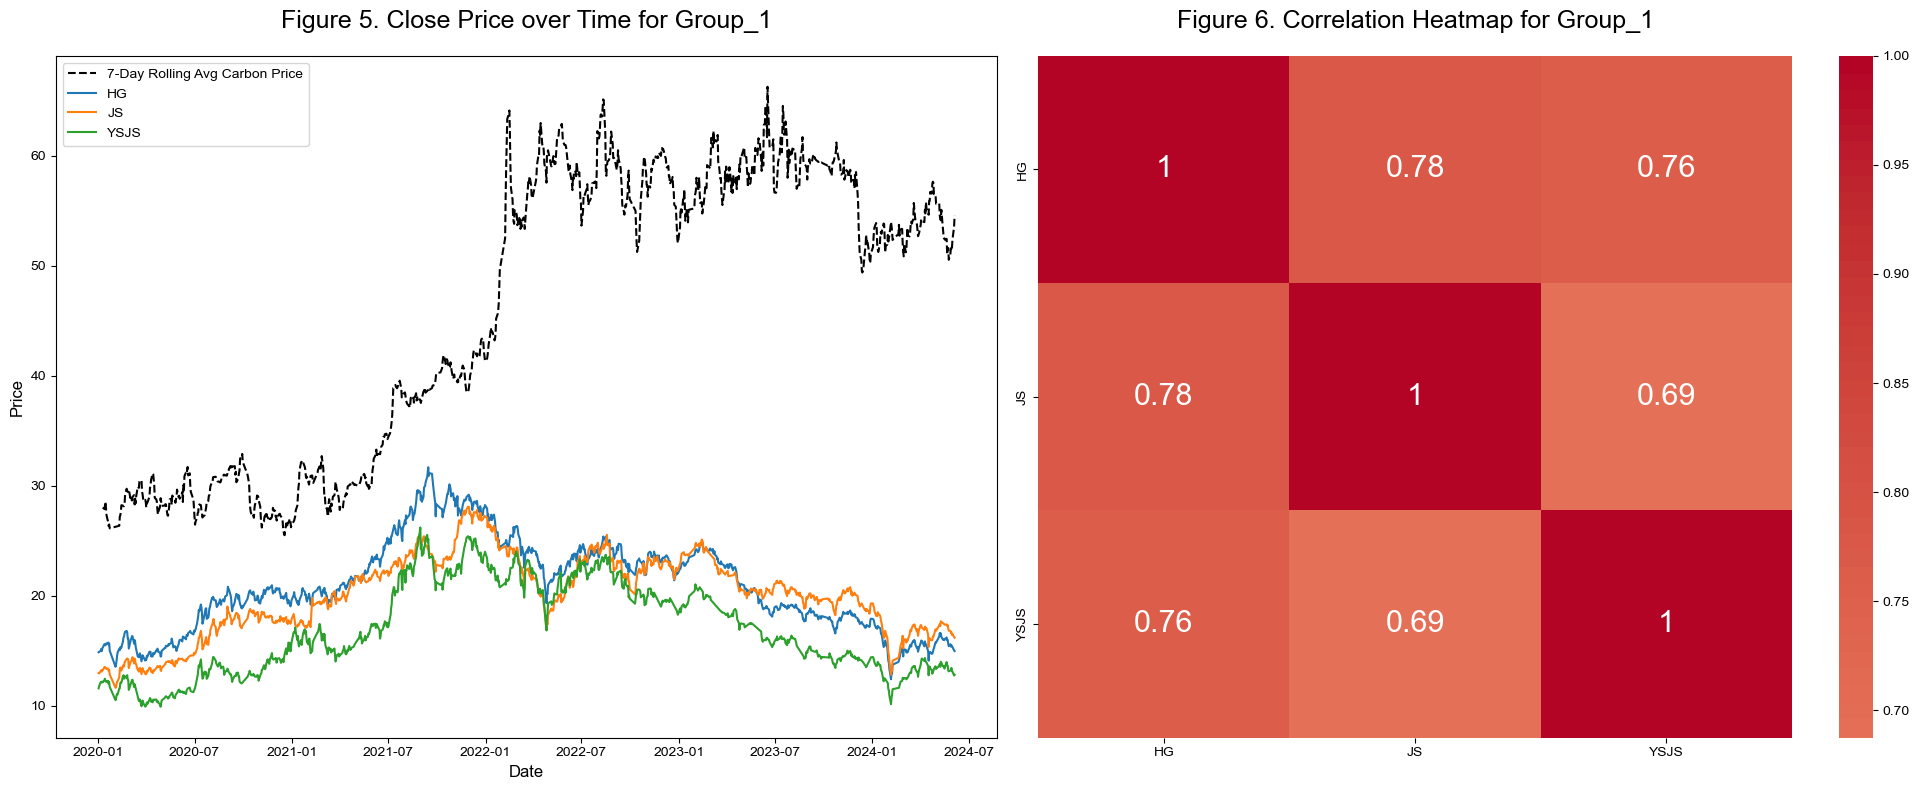

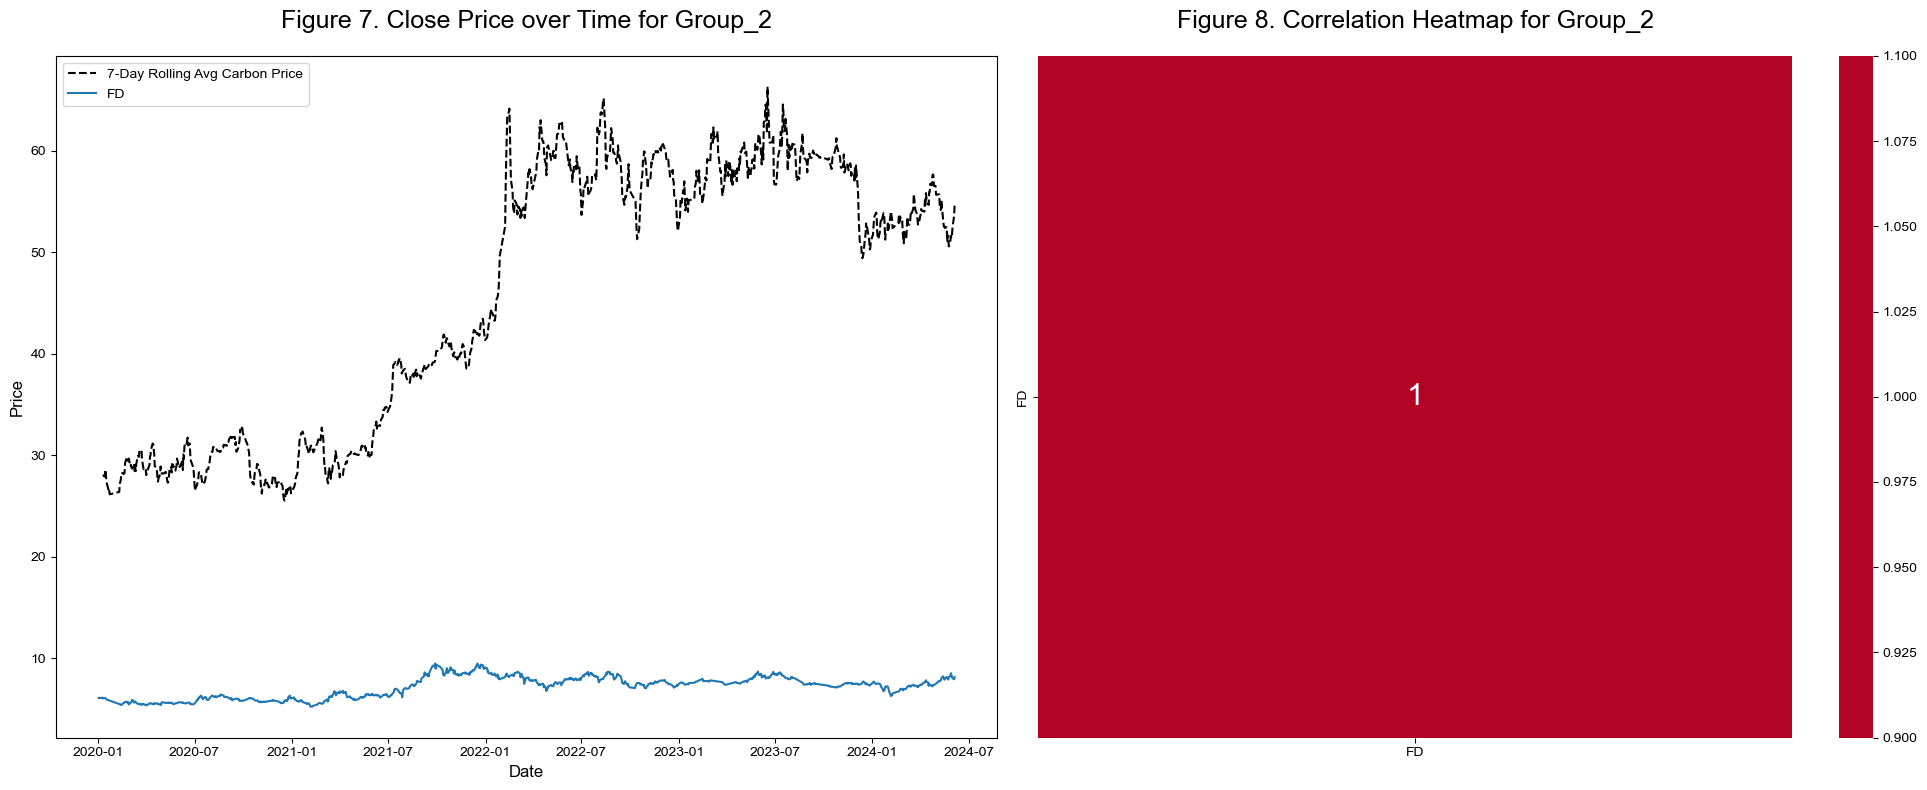

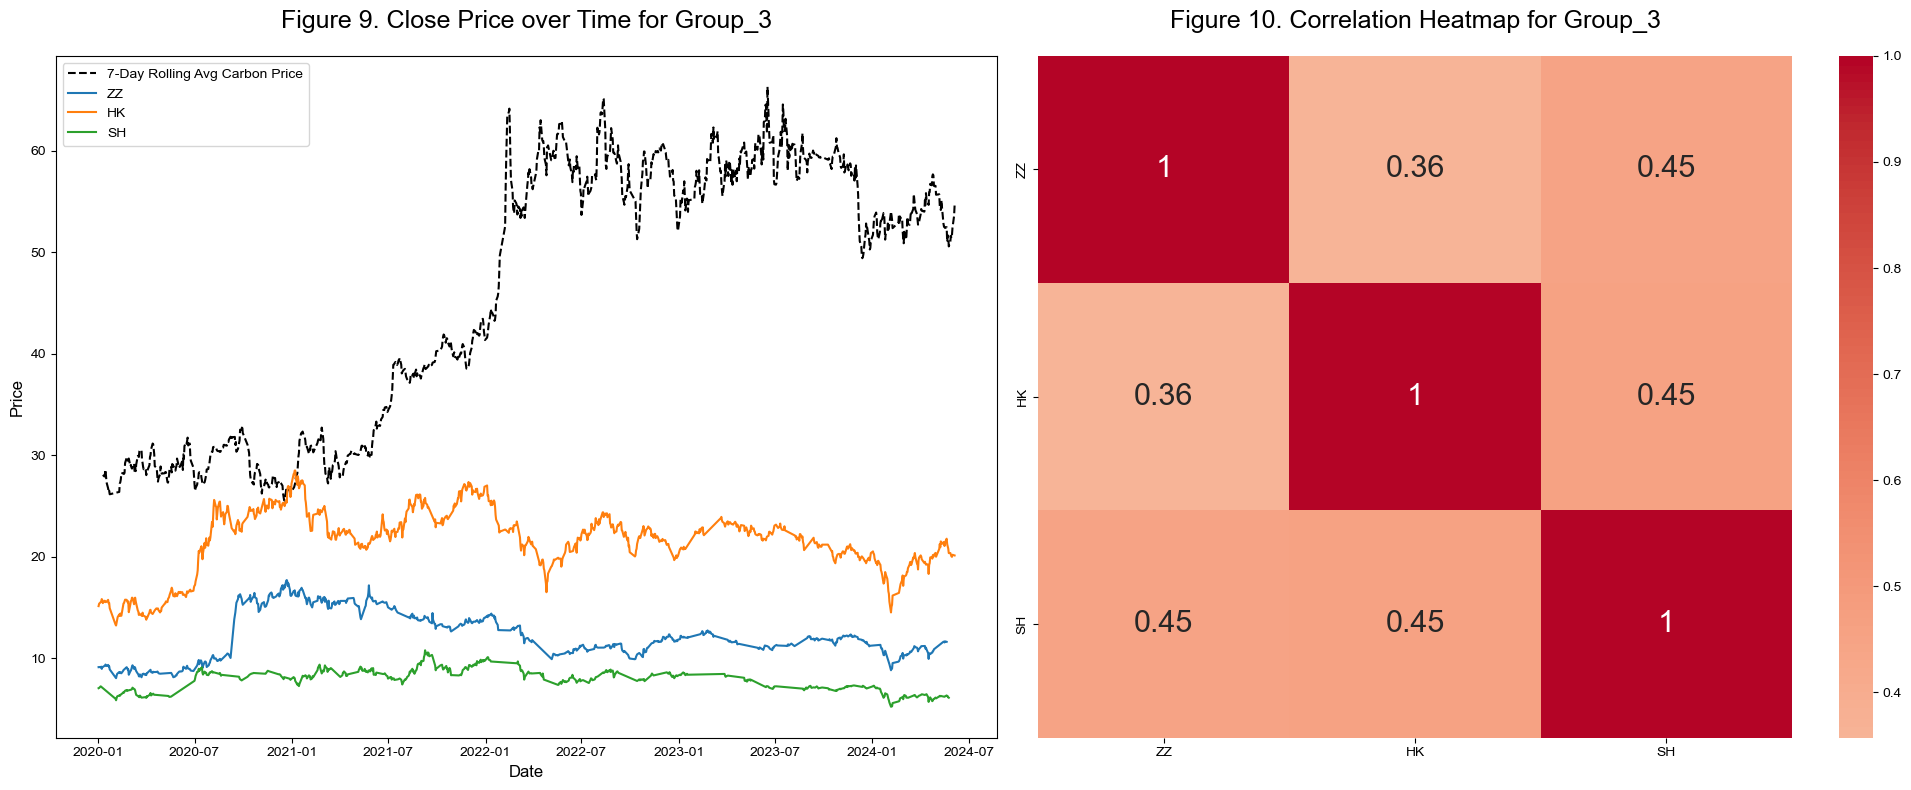

In [170]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Convert date columns to datetime format
carbon_market['TradingDate'] = pd.to_datetime(carbon_market['TradingDate'])
daily_avg['TradingDate'] = pd.to_datetime(daily_avg['TradingDate'])

carbon_market = carbon_market[['TradingDate', 'AvgPrice']]
daily_avg = daily_avg[['TradingDate', 'RollingAvgPrice']]

figure_counter = 5  # Start from Figure 6

# Plot for each group
for group_idx, (group, industries) in enumerate(grouped_industries.items()):
    fig, axes = plt.subplots(1, 2, figsize=(20, 8))  # Create a subplot with 1 row and 2 columns
    
    # Plot the 7-day rolling average carbon price on the first axis
    sns.lineplot(ax=axes[0], x='TradingDate', y='RollingAvgPrice', data=daily_avg, label='7-Day Rolling Avg Carbon Price', color='black', linestyle='--')
    
    # Plot the close price for each industry in the group on the first axis
    for industry in industries:
        df = industry_data[industry]
        df['TradingDate'] = pd.to_datetime(df['TradingDate'])
        sns.lineplot(ax=axes[0], x='TradingDate', y='ClosePrice', data=df, label=industry)
    
    axes[0].set_xlabel('Date', fontsize=12)
    axes[0].set_ylabel('Price', fontsize=12)
    axes[0].set_title(f'Figure {figure_counter}. Close Price over Time for {group}', fontsize=18, pad=20) 
    axes[0].legend()
    
   
    figure_counter += 1

    # Merge close prices for all industries in the group for the heatmap
    merged_df = pd.DataFrame()
    for industry in industries:
        df = industry_data[industry][['TradingDate', 'Ratio']].copy()
        df.set_index('TradingDate', inplace=True)
        df.rename(columns={'Ratio': industry}, inplace=True)
        if merged_df.empty:
            merged_df = df
        else:
            merged_df = merged_df.join(df, how='outer')
    
    # Calculate the correlation matrix
    correlation_matrix = merged_df.corr()
    
    # Plot the heatmap on the second axis
    sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0, ax=axes[1], annot_kws={"size": 22})  # Adjust font size of annotations
    
    axes[1].set_title(f'Figure {figure_counter}. Correlation Heatmap for {group}', fontsize=18, pad=20)  # Add figure number to the title
    
    # Increment figure counter for the next plot
    figure_counter += 1

    # Adjust layout and save the figure
    plt.tight_layout()
    plt.savefig(f'/Users/apple/Desktop/Group_{group}_Comparison.png')  # Save the combined figure
    plt.show()
    plt.close()

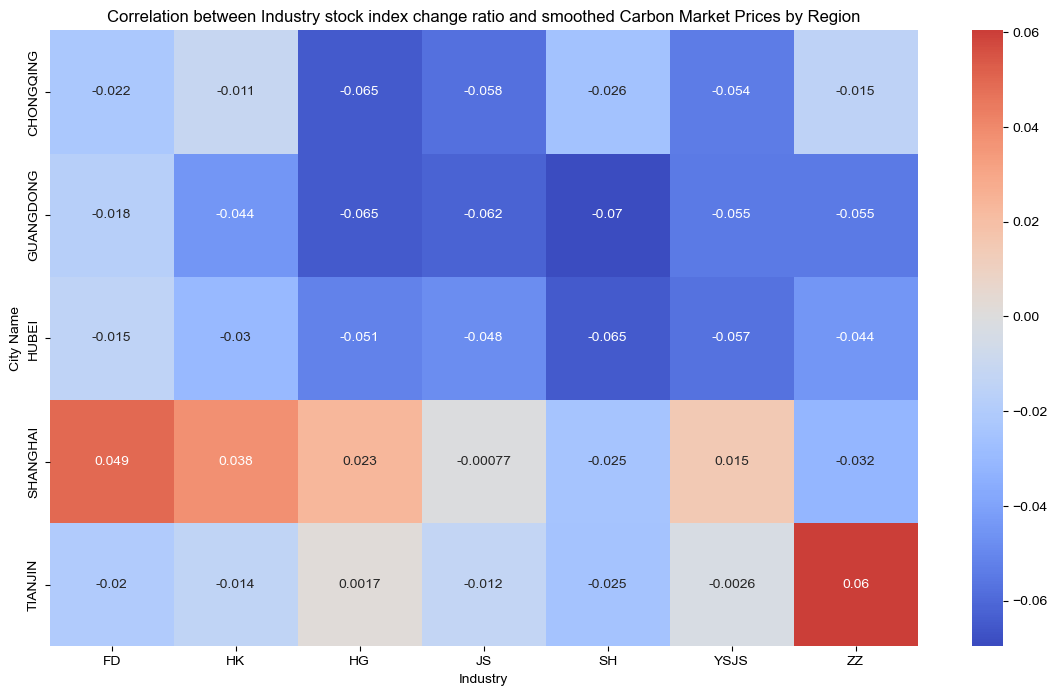

In [65]:
def calculate_returns_and_merge(industry_df, filtered_data_df):
    merged_df = pd.merge(industry_df, filtered_data_df, on='TradingDate', how='inner', suffixes=('', '_Carbon'))
    return merged_df

merged_data_list = {key: calculate_returns_and_merge(df, filtered_data) for key, df in industry_data.items()}


correlation_results = {}

for key, df in merged_data_list.items():
    cities = filtered_data['CityName'].unique()
    correlations = {}
    for city in cities:
        city_data = df[df['CityName'] == city]
        if not city_data.empty:
            correlation = city_data['Ratio'].corr(city_data['SmoothedAvgPrice'])
            correlations[city] = correlation
        else:
            correlations[city] = np.nan 
    correlation_results[key] = correlations


correlation_df = pd.DataFrame(correlation_results)


correlation_df = correlation_df.fillna(0) 


plt.figure(figsize=(14, 8))
sns.heatmap(correlation_df, annot=True, cmap='coolwarm', center=0)
plt.title('Correlation between Industry stock index change ratio and smoothed Carbon Market Prices by Region')
plt.xlabel('Industry')
plt.ylabel('City Name')
plt.show()


In [23]:
# most of the correlation results are small and most of them are negative correlated

In [67]:
merged_data_list

{'FD':      TradingDate   PlateTitle  ClosePrice     Ratio   CityName  AvgPrice  \
 0     2020-01-02  电力、热力生产和供应业       6.068  1.032301  GUANGDONG     28.03   
 1     2020-01-02  电力、热力生产和供应业       6.068  1.032301      HUBEI     26.52   
 2     2020-01-02  电力、热力生产和供应业       6.068  1.032301   SHANGHAI     49.98   
 3     2020-01-02  电力、热力生产和供应业       6.068  1.032301    TIANJIN     15.80   
 4     2020-01-03  电力、热力生产和供应业       6.091  0.379038  GUANGDONG     28.40   
 ...          ...          ...         ...       ...        ...       ...   
 3289  2024-06-03  电力、热力生产和供应业       7.914 -1.456855      HUBEI     41.72   
 3290  2024-06-03  电力、热力生产和供应业       7.914 -1.456855   SHANGHAI     77.67   
 3291  2024-06-04  电力、热力生产和供应业       8.138  2.830427  GUANGDONG     51.63   
 3292  2024-06-04  电力、热力生产和供应业       8.138  2.830427      HUBEI     42.02   
 3293  2024-06-04  电力、热力生产和供应业       8.138  2.830427   SHANGHAI     76.50   
 
       SmoothedAvgPrice  
 0                  NaN  
 1              

In [68]:

group1_industries = ['HG','JS','YSJS']
group2_industries = ['FD']
group3_industries = ['ZZ','HK','SH']


group1_list = []
group2_list = []
group3_list = []


for key, df in merged_data_list.items():
    
    if key in group1_industries:
        group1_list.append(df)
    elif key in group2_industries:
        group2_list.append(df)
    elif key in group3_industries:
        group3_list.append(df)
        


In [69]:
group3_list

[     TradingDate            PlateTitle  ClosePrice     Ratio   CityName  \
 0     2020-01-02  铁路、船舶、航空航天和其他运输设备制造业      15.116  3.583910  GUANGDONG   
 1     2020-01-02  铁路、船舶、航空航天和其他运输设备制造业      15.116  3.583910      HUBEI   
 2     2020-01-02  铁路、船舶、航空航天和其他运输设备制造业      15.116  3.583910   SHANGHAI   
 3     2020-01-02  铁路、船舶、航空航天和其他运输设备制造业      15.116  3.583910    TIANJIN   
 4     2020-01-03  铁路、船舶、航空航天和其他运输设备制造业      15.351  1.554644  GUANGDONG   
 ...          ...                   ...         ...       ...        ...   
 3238  2024-06-03  铁路、船舶、航空航天和其他运输设备制造业      20.126 -0.252763      HUBEI   
 3239  2024-06-03  铁路、船舶、航空航天和其他运输设备制造业      20.126 -0.252763   SHANGHAI   
 3240  2024-06-04  铁路、船舶、航空航天和其他运输设备制造业      20.108 -0.089437  GUANGDONG   
 3241  2024-06-04  铁路、船舶、航空航天和其他运输设备制造业      20.108 -0.089437      HUBEI   
 3242  2024-06-04  铁路、船舶、航空航天和其他运输设备制造业      20.108 -0.089437   SHANGHAI   
 
       AvgPrice  SmoothedAvgPrice  
 0        28.03               NaN  
 1        26.5

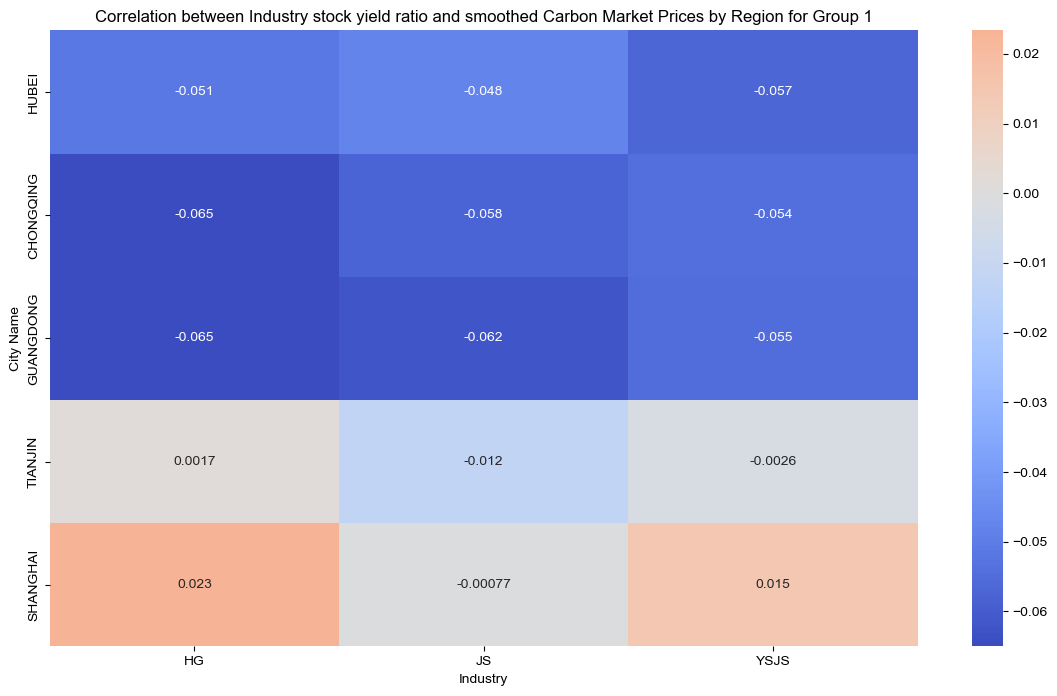

In [70]:
all_cities = set()
for df in group1_list:
    all_cities.update(df['CityName'].unique())

correlation_results = {}


    
    
industry_names = ['HG', 'JS', 'YSJS']

for index, df in enumerate(group1_list):
    correlations = {}
    for city in all_cities:
        city_data = df[df['CityName'] == city]
        if not city_data.empty:
            if 'Ratio' in city_data.columns and 'SmoothedAvgPrice' in city_data.columns:
                correlation = city_data['Ratio'].corr(city_data['SmoothedAvgPrice'])
                correlations[city] = correlation
            else:
                correlations[city] = np.nan  
        else:
            correlations[city] = np.nan  
    correlation_results[industry_names[index]] = correlations  

 

correlation_df = pd.DataFrame(correlation_results)

correlation_df = correlation_df.fillna(0)

plt.figure(figsize=(14, 8))
sns.heatmap(correlation_df, annot=True, cmap='coolwarm', center=0)
plt.title('Correlation between Industry stock yield ratio and smoothed Carbon Market Prices by Region for Group 1')
plt.xlabel('Industry')
plt.ylabel('City Name')
plt.show()


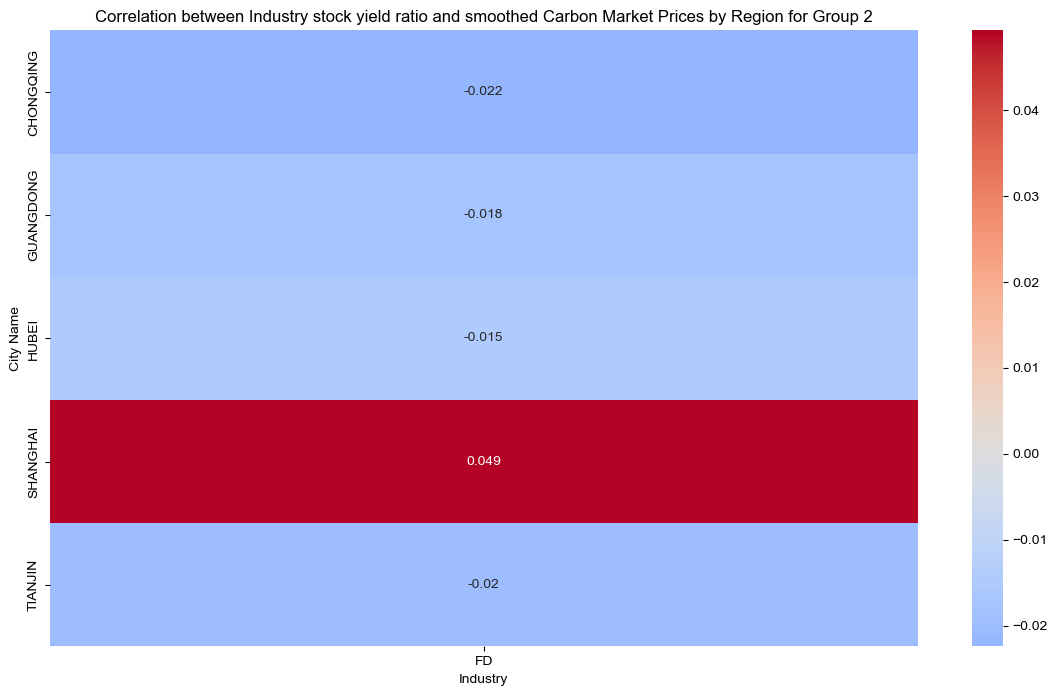

In [71]:

all_cities = set()
for df in group2_list:
    all_cities.update(df['CityName'].unique())

correlation_results = {}

for index, df in enumerate(group2_list):
    correlations = {}
    for city in all_cities:
        city_data = df[df['CityName'] == city]
        if not city_data.empty:
            if 'Ratio' in city_data.columns and 'SmoothedAvgPrice' in city_data.columns:
                correlation = city_data['Ratio'].corr(city_data['SmoothedAvgPrice'])
                correlations[city] = correlation
            else:
                correlations[city] = np.nan 
        else:
            correlations[city] = np.nan 
    correlation_results['FD'] = correlations  

correlation_df = pd.DataFrame(correlation_results)

correlation_df = correlation_df.fillna(0)

plt.figure(figsize=(14, 8))
sns.heatmap(correlation_df, annot=True, cmap='coolwarm', center=0)
plt.title('Correlation between Industry stock yield ratio and smoothed Carbon Market Prices by Region for Group 2')
plt.xlabel('Industry')
plt.ylabel('City Name')
plt.show()


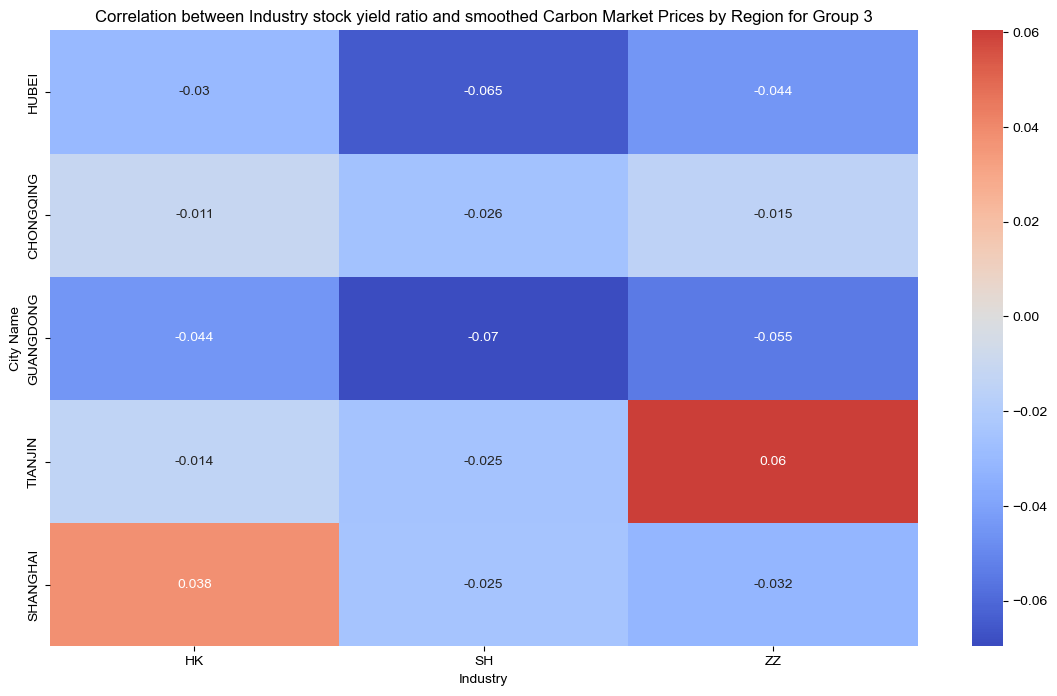

In [72]:

all_cities = set()
for df in group3_list:
    all_cities.update(df['CityName'].unique())

correlation_results = {}



industry_names = ['HK','SH','ZZ']


for index, df in enumerate(group3_list):
    correlations = {}
    for city in all_cities:
        city_data = df[df['CityName'] == city]
        if not city_data.empty:
            if 'Ratio' in city_data.columns and 'SmoothedAvgPrice' in city_data.columns:
                correlation = city_data['Ratio'].corr(city_data['SmoothedAvgPrice'])
                correlations[city] = correlation
            else:
                correlations[city] = np.nan  
        else:
            correlations[city] = np.nan  
    correlation_results[industry_names[index]] = correlations 

 


correlation_df = pd.DataFrame(correlation_results)

correlation_df = correlation_df.fillna(0)

plt.figure(figsize=(14, 8))
sns.heatmap(correlation_df, annot=True, cmap='coolwarm', center=0)
plt.title('Correlation between Industry stock yield ratio and smoothed Carbon Market Prices by Region for Group 3')
plt.xlabel('Industry')
plt.ylabel('City Name')
plt.show()


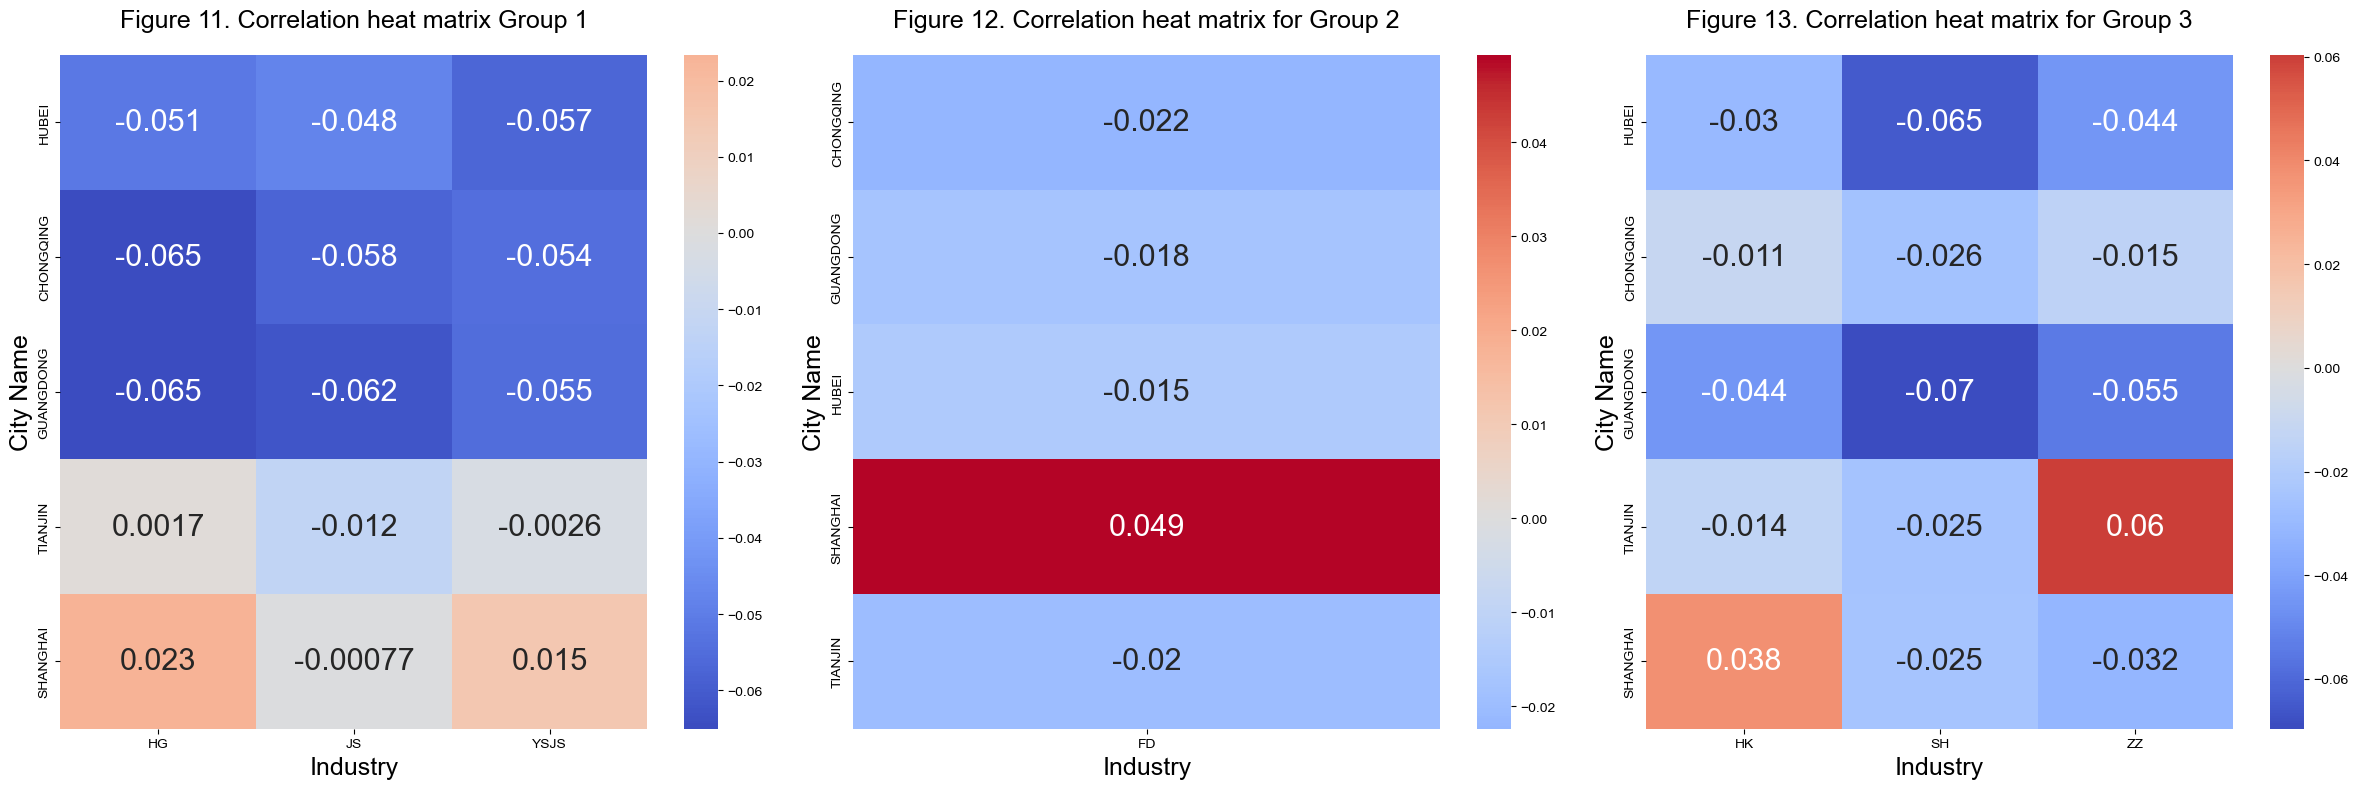

In [79]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

all_cities = set()
for df in group1_list:
    all_cities.update(df['CityName'].unique())

correlation_results = {}

industry_names = ['HG', 'JS', 'YSJS'] 

for index, df in enumerate(group1_list):
    correlations = {}
    for city in all_cities:
        city_data = df[df['CityName'] == city]
        if not city_data.empty:
            if 'Ratio' in city_data.columns and 'SmoothedAvgPrice' in city_data.columns:
                correlation = city_data['Ratio'].corr(city_data['SmoothedAvgPrice'])
                correlations[city] = correlation
            else:
                correlations[city] = np.nan  
        else:
            correlations[city] = np.nan  
    correlation_results[industry_names[index]] = correlations  

correlation_df1 = pd.DataFrame(correlation_results).fillna(0)

# Repeat the process for Group 2
all_cities = set()
for df in group2_list:
    all_cities.update(df['CityName'].unique())

correlation_results = {}

for index, df in enumerate(group2_list):
    correlations = {}
    for city in all_cities:
        city_data = df[df['CityName'] == city]
        if not city_data.empty:
            if 'Ratio' in city_data.columns and 'SmoothedAvgPrice' in city_data.columns:
                correlation = city_data['Ratio'].corr(city_data['SmoothedAvgPrice'])
                correlations[city] = correlation
            else:
                correlations[city] = np.nan  
        else:
            correlations[city] = np.nan  
    correlation_results['FD'] = correlations  

correlation_df2 = pd.DataFrame(correlation_results).fillna(0)

# Repeat the process for Group 3
all_cities = set()
for df in group3_list:
    all_cities.update(df['CityName'].unique())

correlation_results = {}

industry_names = ['HK', 'SH', 'ZZ'] 

for index, df in enumerate(group3_list):
    correlations = {}
    for city in all_cities:
        city_data = df[df['CityName'] == city]
        if not city_data.empty:
            if 'Ratio' in city_data.columns and 'SmoothedAvgPrice' in city_data.columns:
                correlation = city_data['Ratio'].corr(city_data['SmoothedAvgPrice'])
                correlations[city] = correlation
            else:
                correlations[city] = np.nan  
        else:
            correlations[city] = np.nan  
    correlation_results[industry_names[index]] = correlations  

correlation_df3 = pd.DataFrame(correlation_results).fillna(0)


fig, axes = plt.subplots(1, 3, figsize=(24, 8))

sns.heatmap(correlation_df1, annot=True, cmap='coolwarm', center=0, ax=axes[0], annot_kws={"size": 22})
axes[0].set_title('Figure 11. Correlation heat matrix Group 1', fontsize=18,pad=20)
axes[0].set_xlabel('Industry', fontsize=18)
axes[0].set_ylabel('City Name', fontsize=18)

sns.heatmap(correlation_df2, annot=True, cmap='coolwarm', center=0, ax=axes[1], annot_kws={"size": 22})
axes[1].set_title('Figure 12. Correlation heat matrix for Group 2', fontsize=18, pad=20)
axes[1].set_xlabel('Industry', fontsize=18)
axes[1].set_ylabel('City Name', fontsize=18)

sns.heatmap(correlation_df3, annot=True, cmap='coolwarm', center=0, ax=axes[2], annot_kws={"size": 22})
axes[2].set_title('Figure 13. Correlation heat matrix for Group 3', fontsize=18,pad=20)
axes[2].set_xlabel('Industry', fontsize=18)
axes[2].set_ylabel('City Name', fontsize=18)

plt.tight_layout()
plt.savefig('/Users/apple/Desktop/Three_Group_Correlations.png') 
plt.show()
plt.close()


In [80]:
def calculate_returns_and_merge(group_df, daily_avg_df):
   
    group_df['TradingDate'] = pd.to_datetime(group_df['TradingDate'])
    daily_avg_df['TradingDate'] = pd.to_datetime(daily_avg_df['TradingDate'])

    merged_df = pd.merge(group_df, daily_avg_df, on='TradingDate', how='inner', suffixes=('', '_Carbon'))
    return merged_df


In [81]:
def merge_group_data(group_list, daily_avg_df):
    merged_data_list = []
    for df in group_list:
        merged_df = calculate_returns_and_merge(df, daily_avg_df)
        merged_data_list.append(merged_df)
    return merged_data_list


merged_group1_data = merge_group_data(group1_list, daily_avg)
merged_group2_data = merge_group_data(group2_list, daily_avg)
merged_group3_data = merge_group_data(group3_list, daily_avg)




In [82]:
merged_group1_data

[     TradingDate    PlateTitle  ClosePrice     Ratio   CityName  AvgPrice  \
 0     2020-01-02  化学原料和化学制品制造业      14.866  1.780090  GUANGDONG     28.03   
 1     2020-01-02  化学原料和化学制品制造业      14.866  1.780090      HUBEI     26.52   
 2     2020-01-02  化学原料和化学制品制造业      14.866  1.780090   SHANGHAI     49.98   
 3     2020-01-02  化学原料和化学制品制造业      14.866  1.780090    TIANJIN     15.80   
 4     2020-01-03  化学原料和化学制品制造业      14.899  0.221983  GUANGDONG     28.40   
 ...          ...           ...         ...       ...        ...       ...   
 3599  2024-06-03  化学原料和化学制品制造业      15.044 -1.884824      HUBEI     41.72   
 3600  2024-06-03  化学原料和化学制品制造业      15.044 -1.884824   SHANGHAI     77.67   
 3601  2024-06-04  化学原料和化学制品制造业      14.977 -0.445360  GUANGDONG     51.63   
 3602  2024-06-04  化学原料和化学制品制造业      14.977 -0.445360      HUBEI     42.02   
 3603  2024-06-04  化学原料和化学制品制造业      14.977 -0.445360   SHANGHAI     76.50   
 
       SmoothedAvgPrice  DAvgPrice  RollingAvgPrice  
 0      

In [83]:
#### OLS (Ordinary Least Squares) 

# Dependent Variable (Ratio)
# Independent Variable (RollingAvgPrice)

In [88]:

def perform_regression(df):
    df = df.dropna(subset=['RollingAvgPrice', 'Ratio'])  
    X = df['RollingAvgPrice'] 
    Y = df['Ratio']     
    X = sm.add_constant(X) 
    model = sm.OLS(Y, X).fit()  
    return model


industry_names = ['HG', 'JS', 'YSJS']  
for name, df in zip(industry_names, merged_group1_data):
    model = perform_regression(df)
    print(f"回归结果 ({name}):")
    print(model.summary())
    print()




回归结果 (HG):
                            OLS Regression Results                            
Dep. Variable:                  Ratio   R-squared:                       0.003
Model:                            OLS   Adj. R-squared:                  0.003
Method:                 Least Squares   F-statistic:                     10.08
Date:                Tue, 10 Sep 2024   Prob (F-statistic):            0.00151
Time:                        10:16:32   Log-Likelihood:                -6784.3
No. Observations:                3581   AIC:                         1.357e+04
Df Residuals:                    3579   BIC:                         1.358e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
const               0.3065     

In [89]:
#all significant,with p-value <0.05,YSJS p<0.05,但解释力低

In [171]:
industry_names = ['FD'] 

for name, df in zip(industry_names, merged_group2_data):
    model = perform_regression(df)
    print(f"Regression Result ({name}):")
    print(model.summary())
    print()




Regression Result (FD):
                            OLS Regression Results                            
Dep. Variable:                  Ratio   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                  0.000
Method:                 Least Squares   F-statistic:                     1.253
Date:                Tue, 10 Sep 2024   Prob (F-statistic):              0.263
Time:                        20:18:19   Log-Likelihood:                -6366.7
No. Observations:                3278   AIC:                         1.274e+04
Df Residuals:                    3276   BIC:                         1.275e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
const             

In [178]:
industry_names = ['HK','SH','ZZ'] 

for name, df in zip(industry_names, merged_group3_data):
    model = perform_regression(df)
    print(f"Regression Result ({name}):")
    print(model.summary())
    print()


Regression Result (HK):
                            OLS Regression Results                            
Dep. Variable:                  Ratio   R-squared:                       0.002
Model:                            OLS   Adj. R-squared:                  0.001
Method:                 Least Squares   F-statistic:                     4.879
Date:                Tue, 10 Sep 2024   Prob (F-statistic):             0.0273
Time:                        20:21:18   Log-Likelihood:                -6653.9
No. Observations:                3220   AIC:                         1.331e+04
Df Residuals:                    3218   BIC:                         1.332e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
const             

In [179]:
#HK SH p<0.05

In [180]:
def calculate_returns_and_merge(industry_df, carbon_market_df):
    merged_df = pd.merge(industry_df, daily_avg, on='TradingDate', how='inner', suffixes=('', '_Carbon'))
    return merged_df

merged_data_list2 = {key: calculate_returns_and_merge(df, daily_avg) for key, df in industry_data.items()}


In [181]:
pip install statsmodels



[notice] A new release of pip is available: 24.0 -> 24.2
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [182]:
def check_cointegration(df, columns):
    
    data = df[columns].dropna().astype(float)
    
    coint_test = vecm.coint_johansen(data, det_order=0, k_ar_diff=1)
   
    coint_exists = any(coint_test.lr1 > coint_test.cvt[:, 1])
    return coint_exists


In [183]:
industry_names_group1 = ['HG','JS','YSJS']
industry_names_group2 = ['FD']
industry_names_group3 = ['HK','SH','ZZ']

merged_group1_data_dict = {name: df for name, df in zip(industry_names_group1, merged_group1_data)}
merged_group2_data_dict = {name: df for name, df in zip(industry_names_group2, merged_group2_data)}
merged_group3_data_dict = {name: df for name, df in zip(industry_names_group3, merged_group3_data)}

groups = [merged_group1_data_dict, merged_group2_data_dict, merged_group3_data_dict]  
group_names = ['Group 1', 'Group 2', 'Group 3']


In [184]:
import statsmodels.api as sm
def clean_data(df, column):
  
    df[column] = df[column].replace([np.inf, -np.inf], np.nan)  
    df.dropna(subset=[column], inplace=True)  

def check_stationarity(data, column):
    clean_data(data, column) 
    result = sm.tsa.adfuller(data[column], autolag='AIC') 
    adf_stat, p_value, usedlag, nobs, critical_values, icbest = result
    return p_value < 0.05 



In [185]:
for group_data, group_name in zip(groups, group_names):
    print(f"Stationarity Test Results for {group_name}:")
    for industry, df in group_data.items():
        # Assuming known column names of interest
        if 'Ratio' in df.columns:  # Ensure the column exists
            is_stationary = check_stationarity(df, 'Ratio')
            status = "stationary" if is_stationary else "non-stationary"
            print(f"'Ratio' data for {industry} is {status}.")
        if 'RollingAvgPrice' in df.columns:  # Similarly check another column
            is_stationary = check_stationarity(df, 'RollingAvgPrice')
            status = "stationary" if is_stationary else "non-stationary"
            print(f"'RollingAvgPrice' data for {industry} is {status}.")
    print()  


Stationarity Test Results for Group 1:
'Ratio' data for HG is stationary.
'RollingAvgPrice' data for HG is non-stationary.
'Ratio' data for JS is stationary.
'RollingAvgPrice' data for JS is non-stationary.
'Ratio' data for YSJS is stationary.
'RollingAvgPrice' data for YSJS is non-stationary.

Stationarity Test Results for Group 2:
'Ratio' data for FD is stationary.
'RollingAvgPrice' data for FD is non-stationary.

Stationarity Test Results for Group 3:
'Ratio' data for HK is stationary.
'RollingAvgPrice' data for HK is non-stationary.
'Ratio' data for SH is stationary.
'RollingAvgPrice' data for SH is non-stationary.
'Ratio' data for ZZ is stationary.
'RollingAvgPrice' data for ZZ is non-stationary.



In [186]:

for group_data, group_name in zip(groups, group_names):
    print(f"Cointegration Test Results for {group_name}:")
    for industry, df in group_data.items():
        # Assuming the column names of interest are known
        if check_cointegration(df, ['Ratio', 'RollingAvgPrice']):
            print(f"Cointegration exists for {industry} in {group_name}.")
        else:
            print(f"No cointegration found for {industry} in {group_name}.")
    print()  



Cointegration Test Results for Group 1:
Cointegration exists for HG in Group 1.
Cointegration exists for JS in Group 1.
Cointegration exists for YSJS in Group 1.

Cointegration Test Results for Group 2:
Cointegration exists for FD in Group 2.

Cointegration Test Results for Group 3:
Cointegration exists for HK in Group 3.
Cointegration exists for SH in Group 3.
Cointegration exists for ZZ in Group 3.



In [187]:
#prepare for granger test
groups

[{'HG':      TradingDate    PlateTitle  ClosePrice     Ratio   CityName  AvgPrice  \
  23    2020-01-10  化学原料和化学制品制造业      15.313  0.637487  GUANGDONG     28.99   
  24    2020-01-10  化学原料和化学制品制造业      15.313  0.637487      HUBEI     28.74   
  25    2020-01-10  化学原料和化学制品制造业      15.313  0.637487   SHANGHAI     33.00   
  26    2020-01-10  化学原料和化学制品制造业      15.313  0.637487    TIANJIN     16.00   
  27    2020-01-13  化学原料和化学制品制造业      15.599  1.867694  CHONGQING     28.97   
  ...          ...           ...         ...       ...        ...       ...   
  3599  2024-06-03  化学原料和化学制品制造业      15.044 -1.884824      HUBEI     41.72   
  3600  2024-06-03  化学原料和化学制品制造业      15.044 -1.884824   SHANGHAI     77.67   
  3601  2024-06-04  化学原料和化学制品制造业      14.977 -0.445360  GUANGDONG     51.63   
  3602  2024-06-04  化学原料和化学制品制造业      14.977 -0.445360      HUBEI     42.02   
  3603  2024-06-04  化学原料和化学制品制造业      14.977 -0.445360   SHANGHAI     76.50   
  
        SmoothedAvgPrice  DAvgPrice  Rollin

In [188]:

for group_data in groups:
    for industry, df in group_data.items():
        group_data[industry] = df.fillna(method='ffill').fillna(method='bfill')


In [189]:
import pandas as pd
from statsmodels.tsa.stattools import grangercausalitytests

def granger_causality_tests(df, maxlag, test='ssr_chi2test'):
    """
    Check for Granger causality between two series in a DataFrame.
    :param df: pandas DataFrame containing the two time series.
    :param maxlag: Maximum number of lags to test for Granger causality.
    :param test: Specifies which test statistic to return. Defaults to 'ssr_chi2test'.
    """
    if df.dropna().shape[0] > maxlag:  
        result = grangercausalitytests(df.dropna(), maxlag=maxlag)
        return result
    else:
        return None  


for group_data, group_name in zip(groups, group_names):
    print(f"Granger Causality Test results for {group_name}:")
    for industry, df in group_data.items():
        if 'Ratio' in df.columns and 'RollingAvgPrice' in df.columns:
            print(f"Testing for {industry} in {group_name}:")
            result = granger_causality_tests(df[['Ratio', 'RollingAvgPrice']], maxlag=4)
            if result:
                p_values = [round(result[i + 1][0]['ssr_chi2test'][1], 4) for i in range(4)]
                print(f"P-Values for lags 1 to 4: {p_values}")
            else:
                print(f"Not enough data for Granger Causality test after cleaning for {industry}.")
        else:
            print(f"Missing required columns for {industry} in {group_name}.")
    print()


Granger Causality Test results for Group 1:
Testing for HG in Group 1:

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=1.4793  , p=0.2240  , df_denom=3577, df_num=1
ssr based chi2 test:   chi2=1.4805  , p=0.2237  , df=1
likelihood ratio test: chi2=1.4802  , p=0.2237  , df=1
parameter F test:         F=1.4793  , p=0.2240  , df_denom=3577, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=1.0872  , p=0.3373  , df_denom=3574, df_num=2
ssr based chi2 test:   chi2=2.1774  , p=0.3367  , df=2
likelihood ratio test: chi2=2.1767  , p=0.3368  , df=2
parameter F test:         F=1.0872  , p=0.3373  , df_denom=3574, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=0.9544  , p=0.4133  , df_denom=3571, df_num=3
ssr based chi2 test:   chi2=2.8689  , p=0.4123  , df=3
likelihood ratio test: chi2=2.8678  , p=0.4125  , df=3
parameter F test:         F=0.9544  , p=0.4133  , df_denom=3571, df_num=3

Granger Causalit

In [190]:
for group_data, group_name in zip(groups, group_names):
    print(f"Granger Causality Test results for {group_name}:")
    for industry, df in group_data.items():
        print(f"Testing for {industry} in {group_name}:")
        # 增加滞后数到8
        result = granger_causality_tests(df[['Ratio', 'RollingAvgPrice']], maxlag=8)
        if result:
            p_values = [round(result[i + 1][0]['ssr_chi2test'][1], 4) for i in range(8)]
            print(f"P-Values for lags 1 to 8: {p_values}")
        else:
            print(f"Not enough data for Granger Causality test after cleaning for {industry}.")
    print()


Granger Causality Test results for Group 1:
Testing for HG in Group 1:

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=1.4793  , p=0.2240  , df_denom=3577, df_num=1
ssr based chi2 test:   chi2=1.4805  , p=0.2237  , df=1
likelihood ratio test: chi2=1.4802  , p=0.2237  , df=1
parameter F test:         F=1.4793  , p=0.2240  , df_denom=3577, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=1.0872  , p=0.3373  , df_denom=3574, df_num=2
ssr based chi2 test:   chi2=2.1774  , p=0.3367  , df=2
likelihood ratio test: chi2=2.1767  , p=0.3368  , df=2
parameter F test:         F=1.0872  , p=0.3373  , df_denom=3574, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=0.9544  , p=0.4133  , df_denom=3571, df_num=3
ssr based chi2 test:   chi2=2.8689  , p=0.4123  , df=3
likelihood ratio test: chi2=2.8678  , p=0.4125  , df=3
parameter F test:         F=0.9544  , p=0.4133  , df_denom=3571, df_num=3

Granger Causalit

In [50]:
## granger test not significant

In [192]:
import pandas as pd
from statsmodels.tsa.vector_ar.vecm import VECM
from statsmodels.stats.diagnostic import acorr_ljungbox, het_arch
from statsmodels.stats.stattools import jarque_bera
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.vector_ar.vecm import coint_johansen



def vecm_analysis(groups):
    for group_name, group_data in groups.items():
        print(f"\nGroup: {group_name}")
        for industry, df in group_data.items():
            df['TradingDate'] = pd.to_datetime(df['TradingDate'])
            df = df.drop_duplicates(subset='TradingDate')
            df.set_index('TradingDate', inplace=True)
            df = df.asfreq('D')
            df = df[['Ratio', 'RollingAvgPrice']].dropna()

            
            print(f"\nFor Industry {industry}:")

            print(f"\nJohansen Cointegration Test for {industry}:")
            coint_test = coint_johansen(df, det_order=0, k_ar_diff=1)
            
            if any(coint_test.lr1 > coint_test.cvt[:, 1]):
                print(f"Cointegration exists for {industry} in its group.")

            model = VECM(df, coint_rank=1)
            vecm_res = model.fit()
    
            residuals = vecm_res.resid
            
            for i in range(residuals.shape[1]):  
                print(f"\nResiduals analysis for {industry}, Variable {i}:")

                lb_result = acorr_ljungbox(residuals[:, i], lags=[min(10, len(df)//5)], return_df=True)
                print(f"Ljung-Box test:\n{lb_result}\n")
                
                # ARCH
                arch_result = het_arch(residuals[:, i])
                print(f"ARCH Test: p-value = {arch_result[1]}\n")
                
                jb_result = jarque_bera(residuals[:, i])
                print(f"Jarque-Bera Test: JB Statistic = {jb_result[0]}, p-value = {jb_result[1]}\n")
                
              
                adf_residual = adfuller(residuals[:, i])
                print(f"Residual ADF Test for Variable {i}: ADF Statistic = {adf_residual[0]}, p-value = {adf_residual[1]}")


            print(f"\nModel summary:")
            print(vecm_res.summary())


groups = {
    'Group 1': merged_group1_data_dict,
    'Group 2': merged_group2_data_dict,
    'Group 3': merged_group3_data_dict
}
vecm_analysis(groups)



Group: Group 1

For Industry HG:

Johansen Cointegration Test for HG:
Cointegration exists for HG in its group.

Residuals analysis for HG, Variable 0:
Ljung-Box test:
      lb_stat  lb_pvalue
10  12.974639   0.225093

ARCH Test: p-value = 2.6742989368204835e-13

Jarque-Bera Test: JB Statistic = 116.35308211432006, p-value = 5.423120353032167e-26

Residual ADF Test for Variable 0: ADF Statistic = -32.36641407154833, p-value = 0.0

Residuals analysis for HG, Variable 1:
Ljung-Box test:
       lb_stat     lb_pvalue
10  159.014373  5.176112e-29

ARCH Test: p-value = 8.268501213737403e-14

Jarque-Bera Test: JB Statistic = 1063.3246449854053, p-value = 1.2646987972937765e-231

Residual ADF Test for Variable 1: ADF Statistic = -7.87707139111712, p-value = 4.812198394917848e-12

Model summary:
 Det. terms outside the coint. relation & lagged endog. parameters for equation Ratio 
                         coef    std err          z      P>|z|      [0.025      0.975]
---------------------------

/Users/apple/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/apple/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/apple/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Residual ADF Test for Variable 0: ADF Statistic = -19.17987578110123, p-value = 0.0

Residuals analysis for YSJS, Variable 1:
Ljung-Box test:
      lb_stat  lb_pvalue
10  40.928347   0.000012

ARCH Test: p-value = 3.801481486911685e-12

Jarque-Bera Test: JB Statistic = 1102.3203473811054, p-value = 4.307030243628737e-240

Residual ADF Test for Variable 1: ADF Statistic = -8.329557122118281, p-value = 3.3975446596912535e-13

Model summary:
 Det. terms outside the coint. relation & lagged endog. parameters for equation Ratio 
                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
L1.Ratio              -0.0043      0.032     -0.133      0.894      -0.067       0.059
L1.RollingAvgPrice    -0.0457      0.088     -0.520      0.603      -0.218       0.127
Det. terms outside the coint. relation & lagged endog. parameters for equation RollingAvgPrice
                         co

/Users/apple/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/apple/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/apple/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Residual ADF Test for Variable 1: ADF Statistic = -16.118906984758997, p-value = 4.9217662293829184e-29

Model summary:
 Det. terms outside the coint. relation & lagged endog. parameters for equation Ratio 
                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
L1.Ratio              -0.0169      0.033     -0.519      0.604      -0.081       0.047
L1.RollingAvgPrice    -0.0242      0.075     -0.323      0.747      -0.171       0.123
Det. terms outside the coint. relation & lagged endog. parameters for equation RollingAvgPrice
                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
L1.Ratio              -0.0075      0.014     -0.544      0.587      -0.035       0.020
L1.RollingAvgPrice     0.2079      0.032      6.522      0.000       0.145       0.270
  

/Users/apple/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


In [193]:
data = {
    'Group': ['Group 1', 'Group 1', 'Group 1', 'Group 1', 'Group 1', 'Group 1', 
              'Group 2', 'Group 2', 
              'Group 3', 'Group 3', 'Group 3', 'Group 3', 'Group 3', 'Group 3'],
    'Industry': ['HG', 'HG', 'JS', 'JS', 'YSJS', 'YSJS', 
                 'FD', 'FD', 
                 'HK', 'HK', 'SH', 'SH', 'ZZ','ZZ'],
    'Variable': ['Ratio', 'RollingAvgPrice', 'Ratio', 'RollingAvgPrice', 'Ratio', 'RollingAvgPrice', 
                 'Ratio', 'RollingAvgPrice', 
                 'Ratio', 'RollingAvgPrice', 'Ratio', 'RollingAvgPrice', 'Ratio','RollingAvgPrice'],
    'p-value to Ratio Equation': [0.144, 0.000, 0.976, 0.000, 0.344, 0.000, 
                    0.425, 0.000, 
                    0.587, 0.000, 0.948, 0.075, 0.312, 0.182], 
    
    'P-value to RollingAvgPrice Equation': [0.115, 0.472, 0.469, 0.674, 0.894, 0.603, 
                0.147, 0.361, 
                0.604, 0.747, 0.307, 0.252, 0.318, 0.798], 
    
    
}


# 创建DataFrame
df1 = pd.DataFrame(data)

# 设置更适合阅读的索引
df1.set_index(['Group', 'Industry', 'Variable'], inplace=True)

# 显示表格
print(df1)



                                  p-value to Ratio Equation  \
Group   Industry Variable                                     
Group 1 HG       Ratio                                0.144   
                 RollingAvgPrice                      0.000   
        JS       Ratio                                0.976   
                 RollingAvgPrice                      0.000   
        YSJS     Ratio                                0.344   
                 RollingAvgPrice                      0.000   
Group 2 FD       Ratio                                0.425   
                 RollingAvgPrice                      0.000   
Group 3 HK       Ratio                                0.587   
                 RollingAvgPrice                      0.000   
        SH       Ratio                                0.948   
                 RollingAvgPrice                      0.075   
        ZZ       Ratio                                0.312   
                 RollingAvgPrice                      0

In [194]:

data = {
    'Group': ['Group 1', 'Group 1', 'Group 1', 'Group 2', 'Group 3', 'Group 3', 'Group 3'],
    'Industry': ['HG', 'JS', 'YSJS', 'FD', 'HK', 'SH', 'ZZ'],
    'Variable': ['ec1', 'ec1', 'ec1', 'ec1','ec1', 'ec1', 'ec1'],
    
    'P-value to RollingAvgPrice（ECM）': [0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000] 
}

df2 = pd.DataFrame(data)

df2.set_index(['Group', 'Industry', 'Variable'], inplace=True)

print(df2)


                           P-value to RollingAvgPrice（ECM）
Group   Industry Variable                                 
Group 1 HG       ec1                                   0.0
        JS       ec1                                   0.0
        YSJS     ec1                                   0.0
Group 2 FD       ec1                                   0.0
Group 3 HK       ec1                                   0.0
        SH       ec1                                   0.0
        ZZ       ec1                                   0.0



Processing Group 1

Processing Group 2

Processing Group 3


/Users/apple/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/apple/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/apple/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/apple/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.

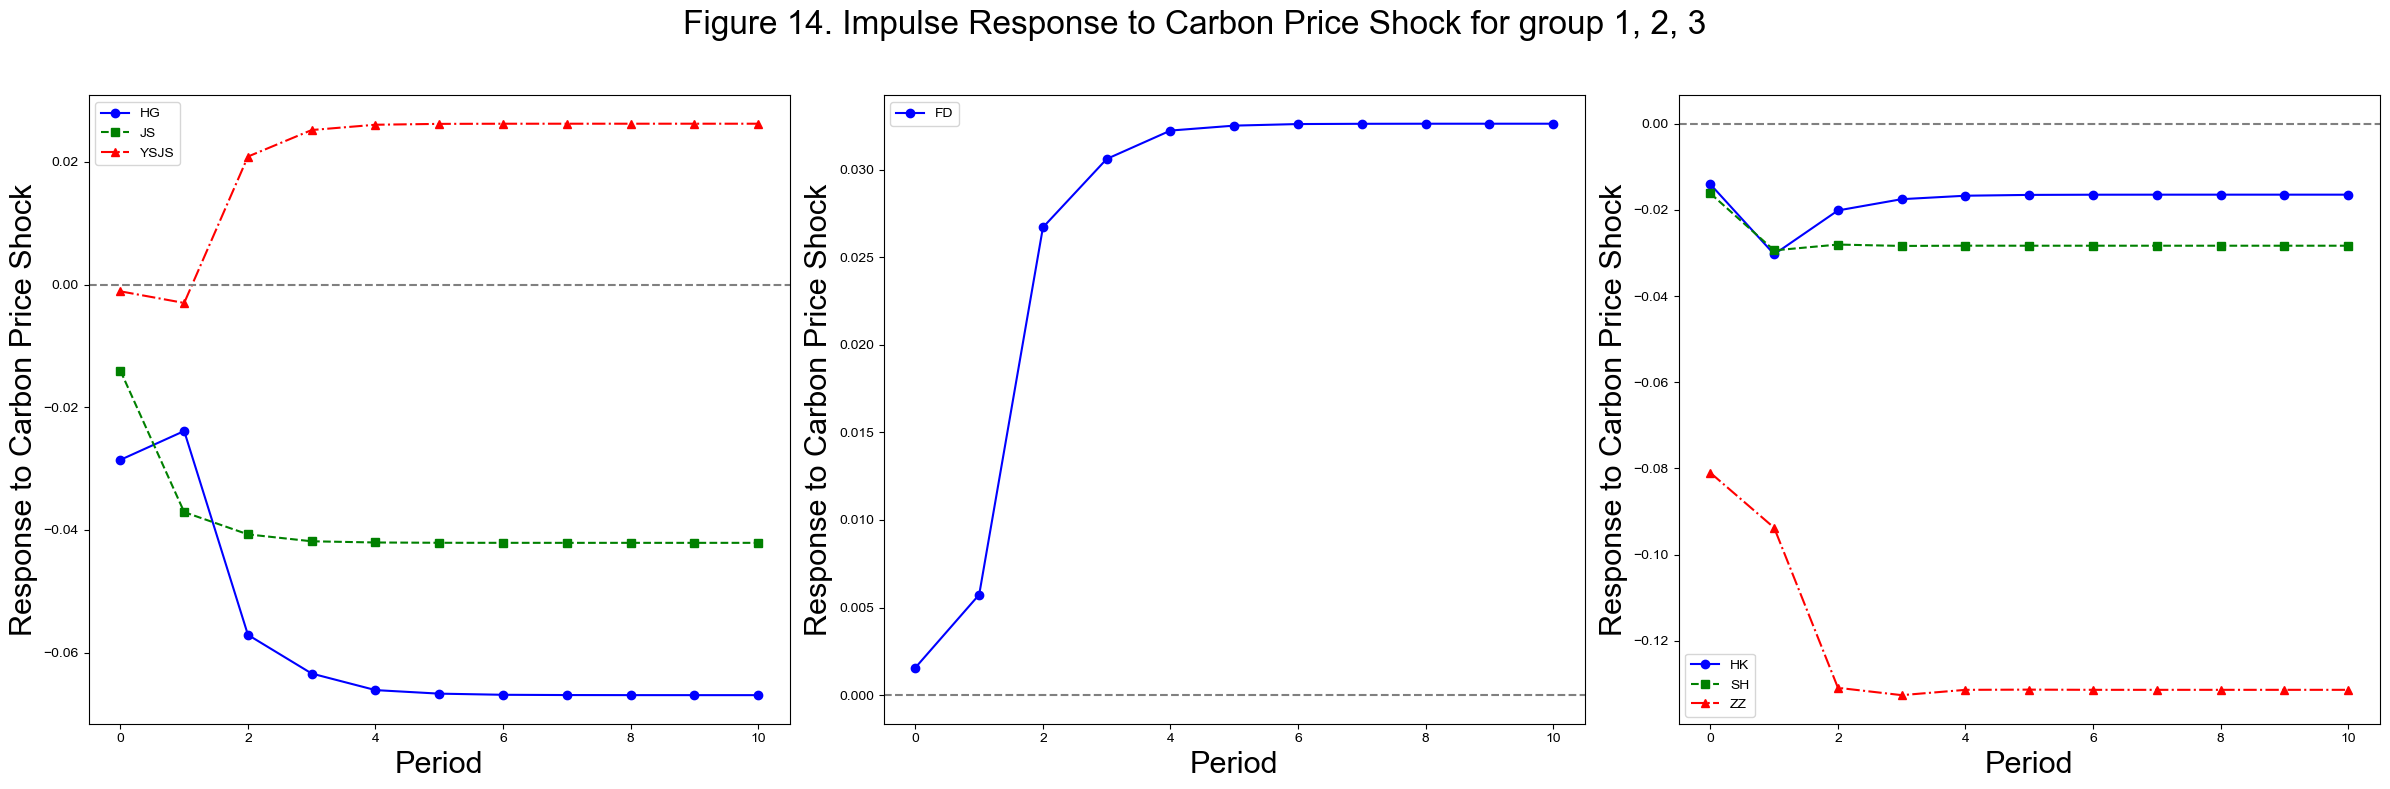

In [195]:


def plot_vecm_irf(groups, periods=10):
    markers = ['o', 's', '^', 'D', 'x', '*', 'p']  
    lines = ['-', '--', '-.', ':', '-', '--', '-.']  
    colors = ['b', 'g', 'r', 'c', 'm', 'y', 'k'] 

    
    fig, axes = plt.subplots(1, 3, figsize=(24, 8))

    for idx, (group_name, group_data) in enumerate(groups.items()):
        ax = axes[idx] 
        print(f"\nProcessing {group_name}")
        
        for ind_idx, (industry, df) in enumerate(group_data.items()):
            df['TradingDate'] = pd.to_datetime(df['TradingDate'])
            df = df.drop_duplicates(subset='TradingDate')
            df.set_index('TradingDate', inplace=True)
            df = df.asfreq('D')
            df = df[['Ratio', 'RollingAvgPrice']].dropna()

            if df.empty or df.shape[0] < 2:
                print(f"Not enough data for {industry} in {group_name}")
                continue

            coint_test = coint_johansen(df, det_order=0, k_ar_diff=1)
            if any(coint_test.lr1 > coint_test.cvt[:, 1]):
                
                model = VECM(df, coint_rank=1)
                vecm_res = model.fit()

                irf = vecm_res.irf(periods)
                irf_values = irf.orth_irfs[:, 1, 0]  

                ax.plot(range(periods + 1), irf_values, label=industry, 
                        marker=markers[ind_idx % len(markers)], 
                        linestyle=lines[ind_idx % len(lines)], 
                        color=colors[ind_idx % len(colors)])
            else:
                print(f"No cointegration found for {industry} in {group_name}")

        ax.axhline(y=0, color='gray', linestyle='--')
        ax.set_xlabel('Period', fontsize=22)
        ax.set_ylabel('Response to Carbon Price Shock', fontsize=22)
        ax.legend(loc='best')

   
    plt.suptitle('Figure 14. Impulse Response to Carbon Price Shock for group 1, 2, 3', fontsize=24)
    
    plt.tight_layout(rect=[0, 0, 1, 0.95])  
    plt.savefig('/Users/apple/Desktop/14Three_Group_VECM_IRF.png')  
    plt.show()
    plt.close()

groups = {
    'Group 1': merged_group1_data_dict,
    'Group 2': merged_group2_data_dict,
    'Group 3': merged_group3_data_dict
}

plot_vecm_irf(groups)

In [118]:
#This chart shows that rising carbon prices have a significant negative impact
#on the share prices of these industries,


Processing Group 1

Processing Group 2

Processing Group 3


/Users/apple/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/apple/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/apple/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/apple/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.

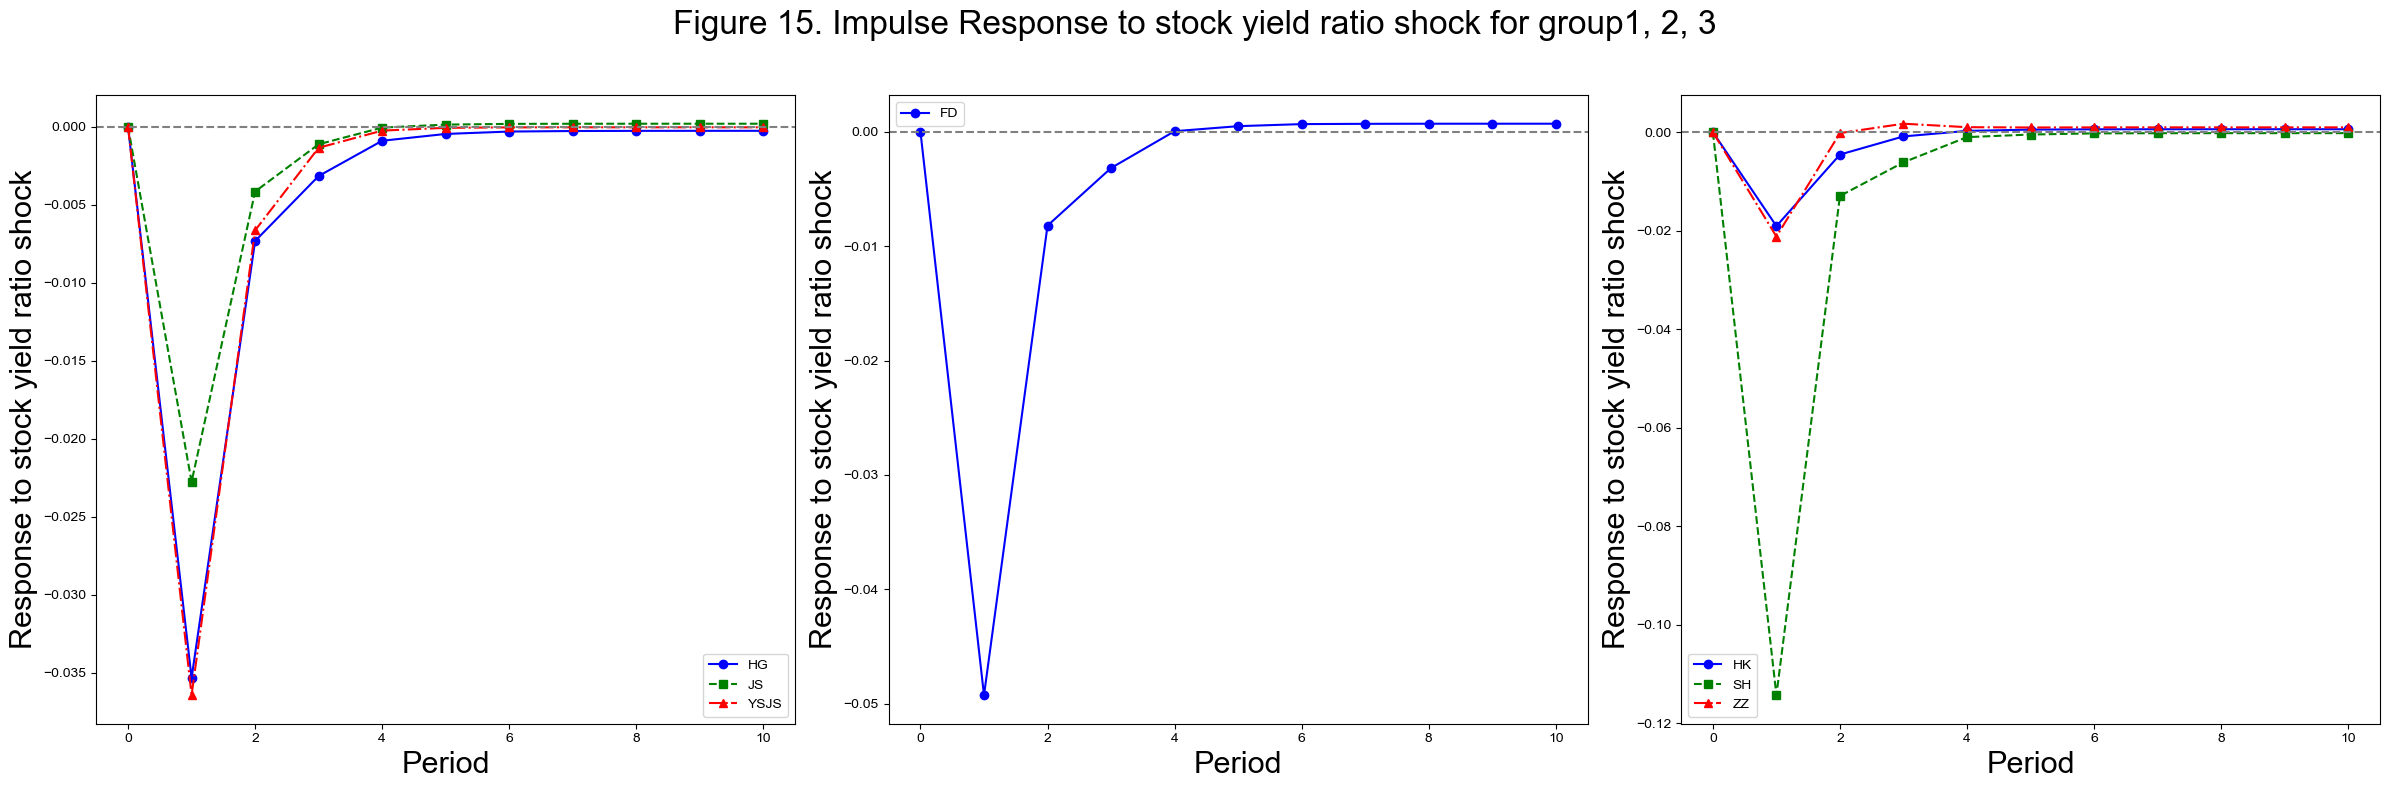

In [196]:
def plot_vecm_irf(groups, periods=10):
    markers = ['o', 's', '^', 'D', 'x', '*', 'p']  
    lines = ['-', '--', '-.', ':', '-', '--', '-.']  
    colors = ['b', 'g', 'r', 'c', 'm', 'y', 'k']  

    
    fig, axes = plt.subplots(1, 3, figsize=(24, 8))

    for idx, (group_name, group_data) in enumerate(groups.items()):
        ax = axes[idx]  
        print(f"\nProcessing {group_name}")
        
        for ind_idx, (industry, df) in enumerate(group_data.items()):
            df['TradingDate'] = pd.to_datetime(df['TradingDate'])
            df = df.drop_duplicates(subset='TradingDate')
            df.set_index('TradingDate', inplace=True)
            df = df.asfreq('D')
            df = df[['Ratio', 'RollingAvgPrice']].dropna()

            if df.empty or df.shape[0] < 2:
                print(f"Not enough data for {industry} in {group_name}")
                continue

            coint_test = coint_johansen(df, det_order=0, k_ar_diff=1)
            if any(coint_test.lr1 > coint_test.cvt[:, 1]):
             
                model = VECM(df, coint_rank=1)
                vecm_res = model.fit()

                irf = vecm_res.irf(periods)
                irf_values = irf.orth_irfs[:, 0, 1] 

                ax.plot(range(periods + 1), irf_values, label=industry, 
                        marker=markers[ind_idx % len(markers)], 
                        linestyle=lines[ind_idx % len(lines)], 
                        color=colors[ind_idx % len(colors)])
            else:
                print(f"No cointegration found for {industry} in {group_name}")

        ax.axhline(y=0, color='gray', linestyle='--')
        ax.set_xlabel('Period', fontsize=22)
        ax.set_ylabel('Response to stock yield ratio shock', fontsize=22)
        ax.legend(loc='best')

   
    plt.suptitle('Figure 15. Impulse Response to stock yield ratio shock for group1, 2, 3', fontsize=24)
    
    plt.tight_layout(rect=[0, 0, 1, 0.95]) 
    plt.savefig('/Users/apple/Desktop/15Three_Group_VECM_IRF.png') 
    plt.show()
    plt.close()

groups = {
    'Group 1': merged_group1_data_dict,
    'Group 2': merged_group2_data_dict,
    'Group 3': merged_group3_data_dict
}

plot_vecm_irf(groups)


In [57]:
#####BEIJING 

In [120]:

beijing_daily = city_daily_avg[city_daily_avg['CityName'] == 'BEIJING'].copy()  # Use .copy() to avoid SettingWithCopyWarning
beijing_daily['TradingDate'] = pd.to_datetime(beijing_daily['TradingDate'])
beijing_daily.sort_values('TradingDate', inplace=True)
beijing_daily.set_index('TradingDate', inplace=True)
beijing_daily = beijing_daily[['AvgPrice']]  # Keeping only the AvgPrice column



In [121]:
beijing_daily.head(10)

AvgPrice
TradingDate          
2020-01-06      73.10
2020-01-07      76.20
2020-01-08      80.10
2020-01-09      84.50
2020-02-18      84.50
2020-03-11      68.00
2020-03-12      81.00
2020-03-13      84.40
2020-03-17      86.10
2020-03-18      83.97

In [122]:

def merge_data(city_data, industry_data):
    merged_data = {}
    for key, df in industry_data.items():
        df = df.set_index('TradingDate')
        merged_df = df.join(city_data, how='inner') 
        merged_data[key] = merged_df
    return merged_data

BJ_merged_data = merge_data(beijing_daily, industry_data)


In [123]:
BJ_merged_data

{'FD':               PlateTitle  ClosePrice     Ratio  AvgPrice
 TradingDate                                             
 2020-01-08   电力、热力生产和供应业       6.052 -0.640289    80.100
 2020-01-09   电力、热力生产和供应业       6.115  1.040978    84.500
 2020-02-18   电力、热力生产和供应业       5.573  0.868778    84.500
 2020-03-11   电力、热力生产和供应业       5.741  1.056152    68.000
 2020-03-12   电力、热力生产和供应业       5.669 -1.254137    81.000
 ...                  ...         ...       ...       ...
 2024-05-23   电力、热力生产和供应业       7.884 -1.952493    99.000
 2024-05-27   电力、热力生产和供应业       8.231  1.242312    89.655
 2024-05-28   电力、热力生产和供应业       8.514  3.438221   102.000
 2024-05-30   电力、热力生产和供应业       8.093 -3.216934   105.000
 2024-06-04   电力、热力生产和供应业       8.138  2.830427    96.000
 
 [509 rows x 4 columns],
 'HK':                        PlateTitle  ClosePrice     Ratio  AvgPrice
 TradingDate                                                      
 2020-01-06   铁路、船舶、航空航天和其他运输设备制造业      15.513  1.055306    73.100
 2020-

In [153]:
import pandas as pd
# Function to merge industry data with city data based on predefined groups
import numpy as np  # Make sure to import NumPy
import pandas as pd

# Example city data (Beijing AvgPrice), ensure this is loaded and indexed by 'TradingDate'
import numpy as np
import pandas as pd

np.random.seed(42)
beijing_daily = pd.DataFrame({
    'TradingDate': pd.date_range(start='2020-01-01', periods=100, freq='D'),
    'AvgPrice': np.random.rand(100) * 100 

beijing_daily.set_index('TradingDate', inplace=True)



grouped_industries = {
    'Group_1': ['HG', 'JS', 'YSJS'],
    'Group_2': ['FD'],
    'Group_3': ['ZZ', 'HK', 'SH']
}

def merge_data(city_data, industry_data, grouped_industries):
    grouped_merged_data = {}
    for group_name, industries in grouped_industries.items():
        for industry in industries:
            if industry in industry_data:
                df = industry_data[industry]
                df = df.set_index('TradingDate')
                merged_df = df.join(city_data, how='inner')  # Inner join with city data
                if group_name not in grouped_merged_data:
                    grouped_merged_data[group_name] = {}
                grouped_merged_data[group_name][industry] = merged_df
    return grouped_merged_data

# Merge data
BJ_grouped_merged_data = merge_data(beijing_daily, industry_data, grouped_industries)

# Display some of the merged data
for group, industries_data in BJ_grouped_merged_data.items():
    print(f"Data for {group}:")
    for industry, data in industries_data.items():
        print(f"Data for industry {industry}:")
        print(data.head()) 



Data for Group_1:
Data for industry HG:
               PlateTitle  ClosePrice     Ratio   AvgPrice
TradingDate                                               
2020-01-02   化学原料和化学制品制造业      14.866  1.780090  95.071431
2020-01-03   化学原料和化学制品制造业      14.899  0.221983  73.199394
2020-01-06   化学原料和化学制品制造业      15.021  0.818847  15.599452
2020-01-07   化学原料和化学制品制造业      15.173  1.011917   5.808361
2020-01-08   化学原料和化学制品制造业      14.961 -1.397219  86.617615
Data for industry JS:
            PlateTitle  ClosePrice     Ratio   AvgPrice
TradingDate                                            
2020-01-02       金属制品业      12.972  1.701294  95.071431
2020-01-03       金属制品业      12.950 -0.169596  73.199394
2020-01-06       金属制品业      13.152  1.559846  15.599452
2020-01-07       金属制品业      13.243  0.691910   5.808361
2020-01-08       金属制品业      13.113 -0.981651  86.617615
Data for industry YSJS:
               PlateTitle  ClosePrice     Ratio   AvgPrice
TradingDate                                       

In [125]:
from statsmodels.tsa.vector_ar.vecm import coint_johansen


def check_cointegration(df, cols):
    if df.dropna().shape[0] > 20: 
        result = coint_johansen(df[cols].dropna(), det_order=0, k_ar_diff=1)
        return result.lr1[0] > result.cvt[0, 1]  # Checking at 95% confidence level
    return False

#cointegration tests
for group, industries_data in BJ_grouped_merged_data.items():
    print(f"Cointegration Test Results for {group}:")
    for industry, data in industries_data.items():
        
        if 'Ratio' in data.columns:
            cointegration_exists = check_cointegration(data, ['AvgPrice', 'Ratio'])
            result_msg = "exists" if cointegration_exists else "does not exist"
            print(f"Cointegration {result_msg} between 'AvgPrice' and 'Ratio' in {industry}")
        else:
            print(f"No suitable data for cointegration tests in {industry}")


Cointegration Test Results for Group_1:
Cointegration exists between 'AvgPrice' and 'Ratio' in HG
Cointegration exists between 'AvgPrice' and 'Ratio' in JS
Cointegration exists between 'AvgPrice' and 'Ratio' in YSJS
Cointegration Test Results for Group_2:
Cointegration exists between 'AvgPrice' and 'Ratio' in FD
Cointegration Test Results for Group_3:
Cointegration exists between 'AvgPrice' and 'Ratio' in ZZ
Cointegration exists between 'AvgPrice' and 'Ratio' in HK
Cointegration exists between 'AvgPrice' and 'Ratio' in SH


In [126]:
#都存在，用VECM

In [127]:
def perform_granger_tests(grouped_data, max_lags=4):
    results = {}
    for group, industries in grouped_data.items():
        results[group] = {}
        for industry, data in industries.items():
            print(f"Performing Granger Causality Test for {industry} in {group}")
           
            if 'Ratio' in data.columns and 'AvgPrice' in data.columns:
                test_result = grangercausalitytests(data[['AvgPrice', 'Ratio']], maxlag=max_lags, verbose=False)
               
                p_value = test_result[1][0]['ssr_chi2test'][1]
                results[group][industry] = p_value
                print(f"Granger Causality p-value for {industry} in {group}: {p_value}")
            else:
                print(f"Required data columns not found in {industry}")
    return results



In [128]:
granger_results = perform_granger_tests(BJ_grouped_merged_data)


Performing Granger Causality Test for HG in Group_1
Granger Causality p-value for HG in Group_1: 0.5167390960228871
Performing Granger Causality Test for JS in Group_1
Granger Causality p-value for JS in Group_1: 0.26489942045135084
Performing Granger Causality Test for YSJS in Group_1
Granger Causality p-value for YSJS in Group_1: 0.8356826859670908
Performing Granger Causality Test for FD in Group_2
Granger Causality p-value for FD in Group_2: 0.23714320218960577
Performing Granger Causality Test for ZZ in Group_3
Granger Causality p-value for ZZ in Group_3: 0.6773525230170371
Performing Granger Causality Test for HK in Group_3
Granger Causality p-value for HK in Group_3: 0.1522871448403549
Performing Granger Causality Test for SH in Group_3
Granger Causality p-value for SH in Group_3: 0.20403198100866635


/Users/apple/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
/Users/apple/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
/Users/apple/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
/Users/apple/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
/Users/apple/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
/Users/apple/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/stattools.py:1488: Fut


Group: Group_1

Cointegration exists for HG in Group_1.
Det. terms outside the coint. relation & lagged endog. parameters for equation Ratio
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
L1.Ratio       -0.0385      0.127     -0.303      0.762      -0.288       0.211
L1.AvgPrice    -0.0003      0.008     -0.044      0.965      -0.015       0.014
Det. terms outside the coint. relation & lagged endog. parameters for equation AvgPrice
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
L1.Ratio        2.7141      1.959      1.386      0.166      -1.125       6.553
L1.AvgPrice    -0.3750      0.116     -3.226      0.001      -0.603      -0.147
               Loading coefficients (alpha) for equation Ratio                
                 coef    std err          z      P>

/Users/apple/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


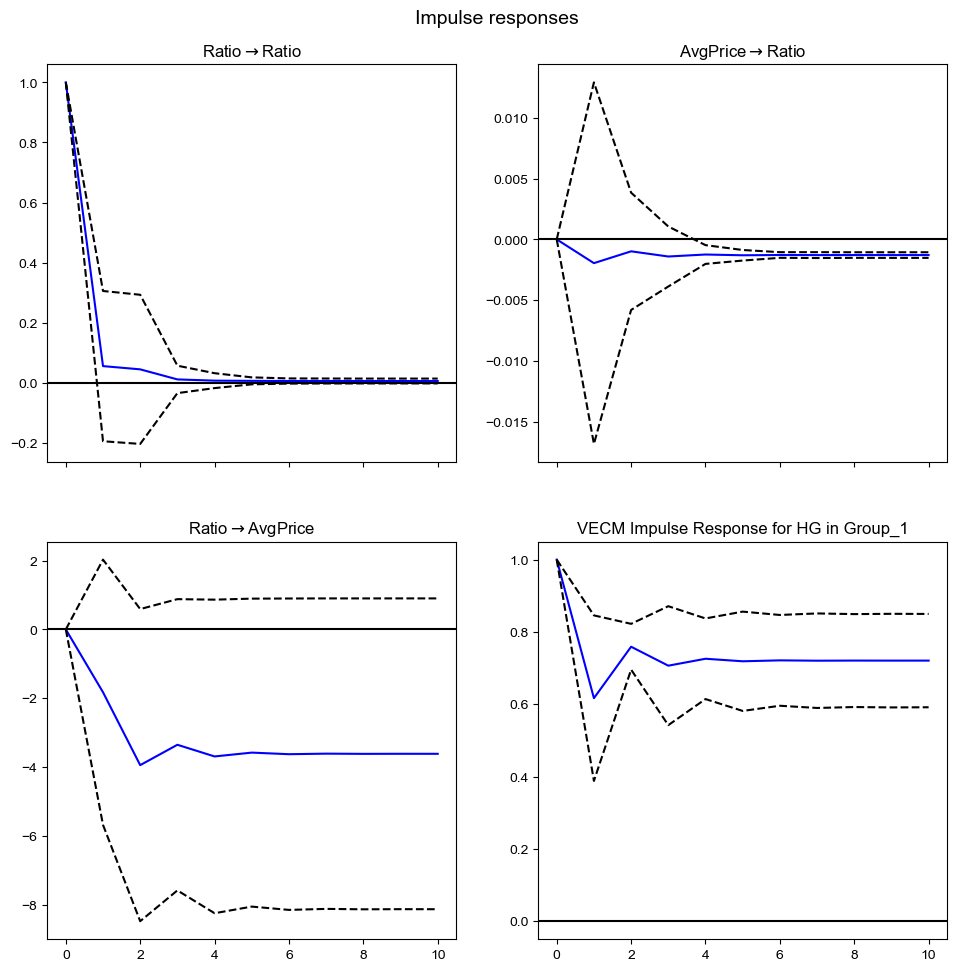


Cointegration exists for JS in Group_1.
Det. terms outside the coint. relation & lagged endog. parameters for equation Ratio
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
L1.Ratio        0.0804      0.127      0.634      0.526      -0.168       0.329
L1.AvgPrice    -0.0049      0.007     -0.671      0.502      -0.019       0.009
Det. terms outside the coint. relation & lagged endog. parameters for equation AvgPrice
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
L1.Ratio        1.8810      2.054      0.916      0.360      -2.144       5.906
L1.AvgPrice    -0.3743      0.117     -3.187      0.001      -0.605      -0.144
               Loading coefficients (alpha) for equation Ratio                
                 coef    std err          z      P>|z|      [0.025 

/Users/apple/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


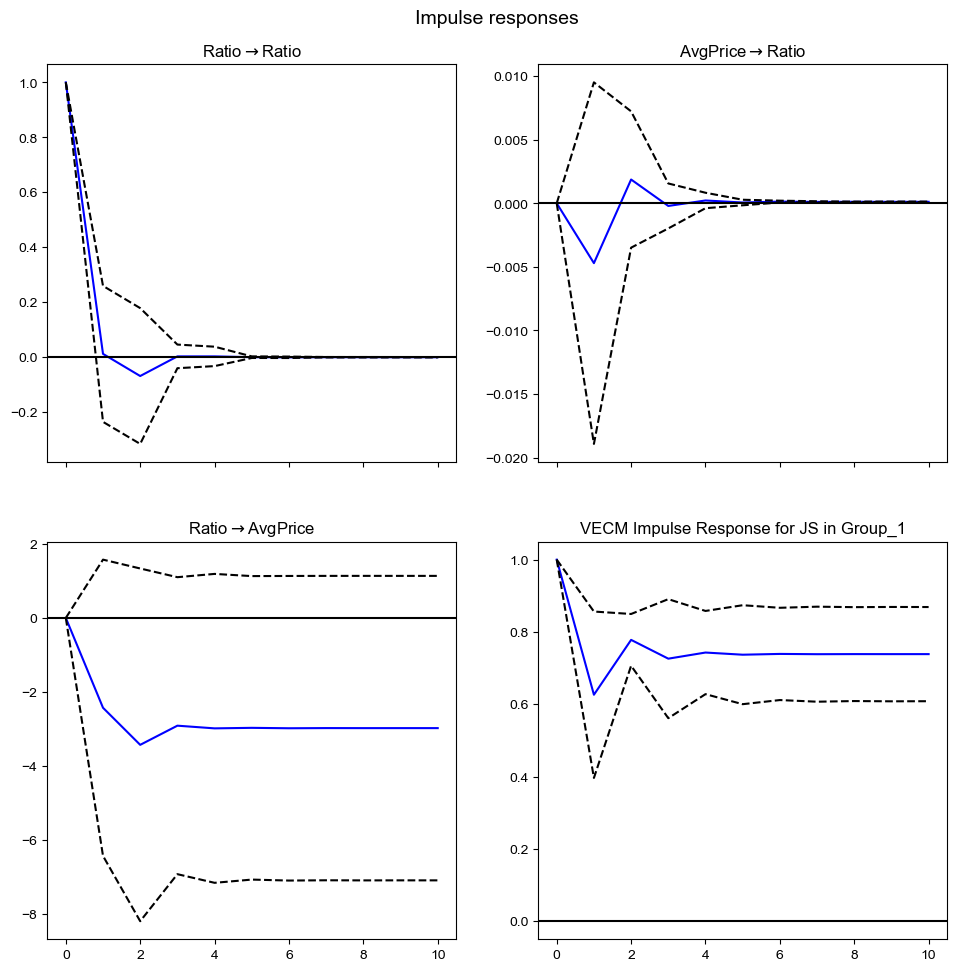


Cointegration exists for YSJS in Group_1.
Det. terms outside the coint. relation & lagged endog. parameters for equation Ratio
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
L1.Ratio        0.0510      0.127      0.403      0.687      -0.197       0.299
L1.AvgPrice     0.0010      0.010      0.105      0.916      -0.018       0.020
Det. terms outside the coint. relation & lagged endog. parameters for equation AvgPrice
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
L1.Ratio        2.6486      1.482      1.787      0.074      -0.257       5.554
L1.AvgPrice    -0.3971      0.116     -3.433      0.001      -0.624      -0.170
               Loading coefficients (alpha) for equation Ratio                
                 coef    std err          z      P>|z|      [0.02

/Users/apple/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


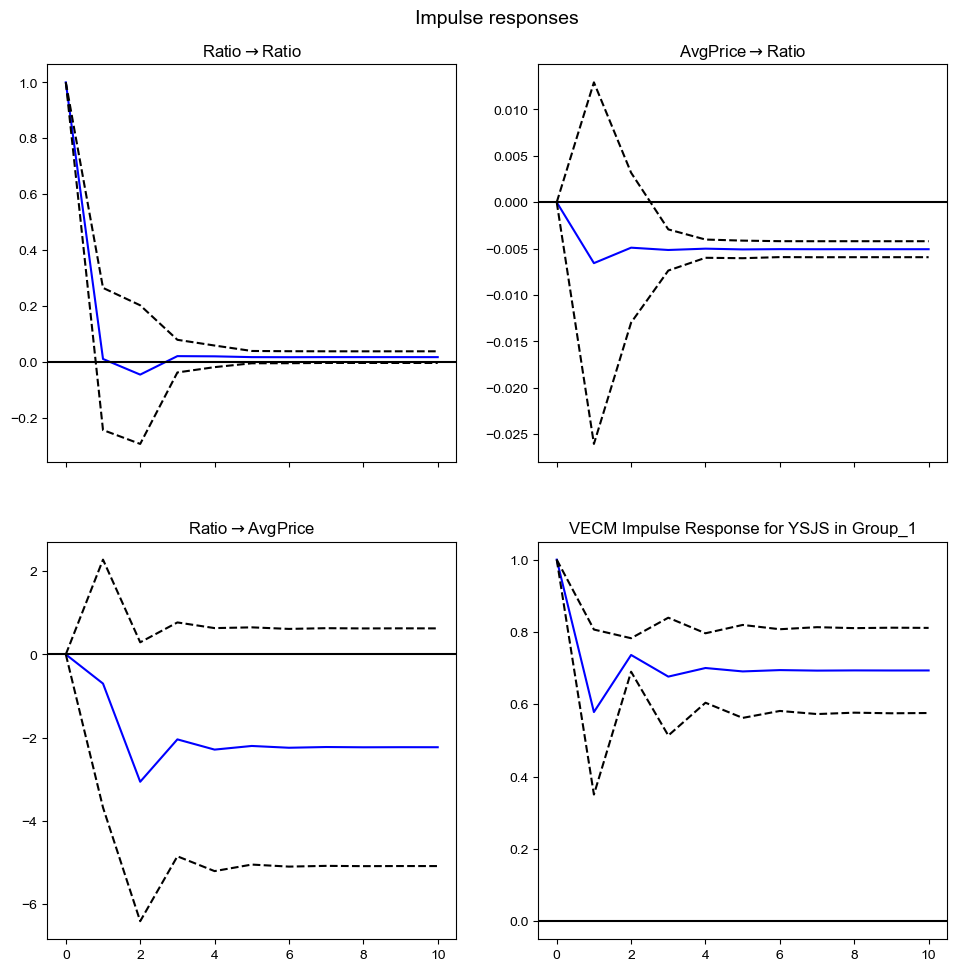


Group: Group_2

Cointegration exists for FD in Group_2.
Det. terms outside the coint. relation & lagged endog. parameters for equation Ratio
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
L1.Ratio        0.0041      0.150      0.027      0.978      -0.289       0.297
L1.AvgPrice    -0.0016      0.007     -0.226      0.822      -0.015       0.012
Det. terms outside the coint. relation & lagged endog. parameters for equation AvgPrice
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
L1.Ratio        3.3690      2.714      1.241      0.215      -1.951       8.689
L1.AvgPrice    -0.4199      0.127     -3.298      0.001      -0.669      -0.170
               Loading coefficients (alpha) for equation Ratio                
                 coef    std err          z      P>

/Users/apple/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


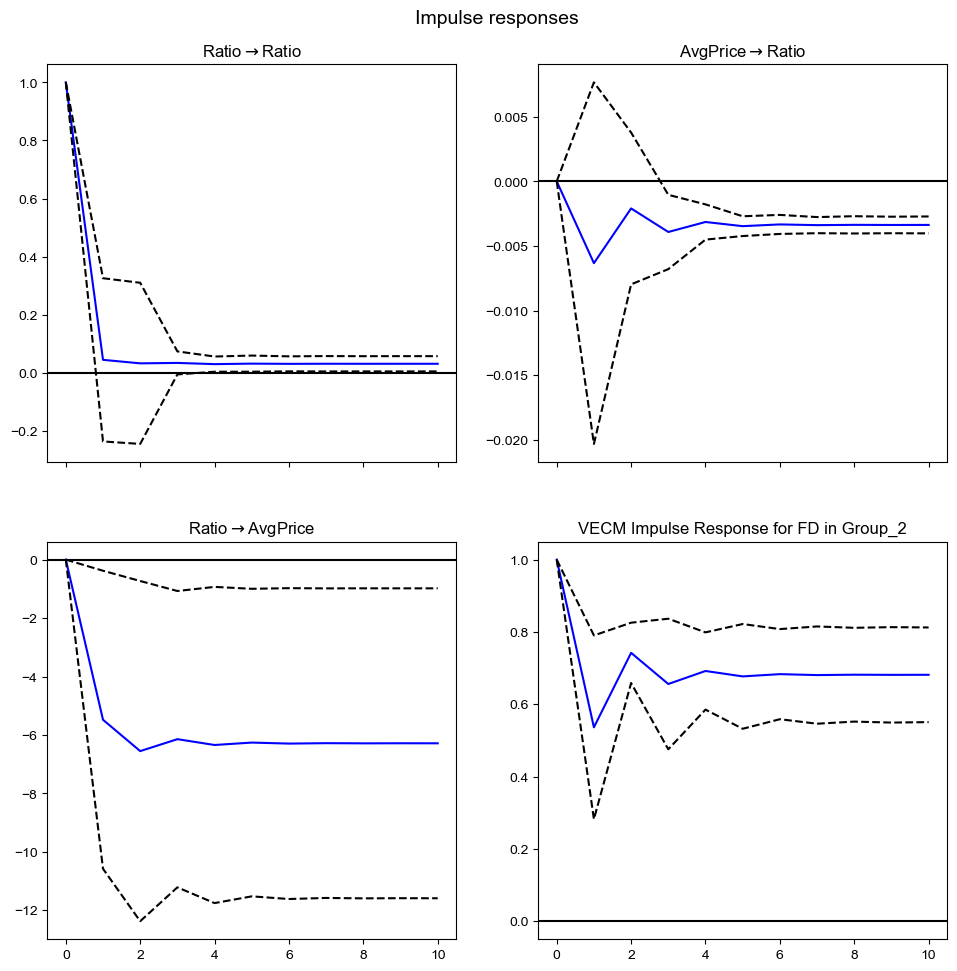


Group: Group_3

Cointegration exists for ZZ in Group_3.
Det. terms outside the coint. relation & lagged endog. parameters for equation Ratio
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
L1.Ratio       -0.0799      0.131     -0.610      0.542      -0.337       0.177
L1.AvgPrice    -0.0007      0.007     -0.094      0.925      -0.015       0.014
Det. terms outside the coint. relation & lagged endog. parameters for equation AvgPrice
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
L1.Ratio        4.3313      2.089      2.074      0.038       0.238       8.425
L1.AvgPrice    -0.3381      0.118     -2.865      0.004      -0.569      -0.107
               Loading coefficients (alpha) for equation Ratio                
                 coef    std err          z      P>

/Users/apple/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


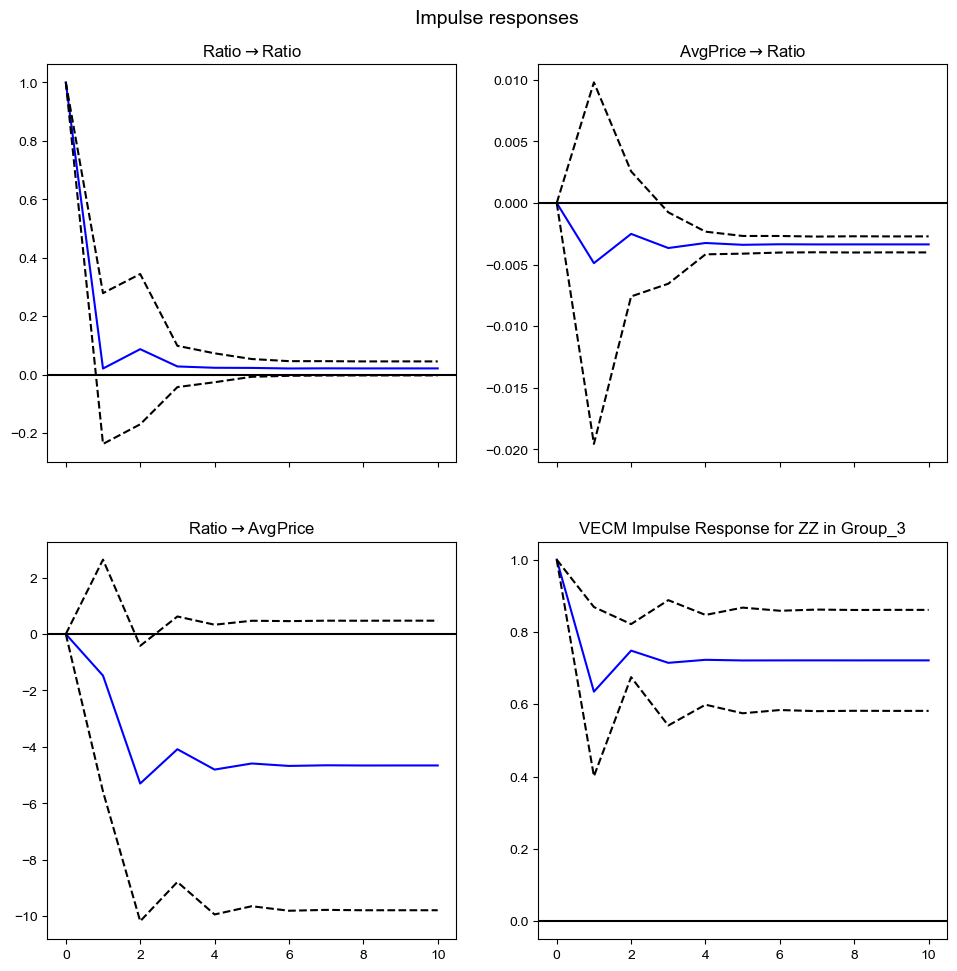


Cointegration exists for HK in Group_3.
Det. terms outside the coint. relation & lagged endog. parameters for equation Ratio
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
L1.Ratio        0.0055      0.129      0.043      0.966      -0.248       0.259
L1.AvgPrice    -0.0049      0.008     -0.608      0.544      -0.021       0.011
Det. terms outside the coint. relation & lagged endog. parameters for equation AvgPrice
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
L1.Ratio        3.0180      1.864      1.619      0.105      -0.635       6.671
L1.AvgPrice    -0.3746      0.116     -3.219      0.001      -0.603      -0.147
               Loading coefficients (alpha) for equation Ratio                
                 coef    std err          z      P>|z|      [0.025 

/Users/apple/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


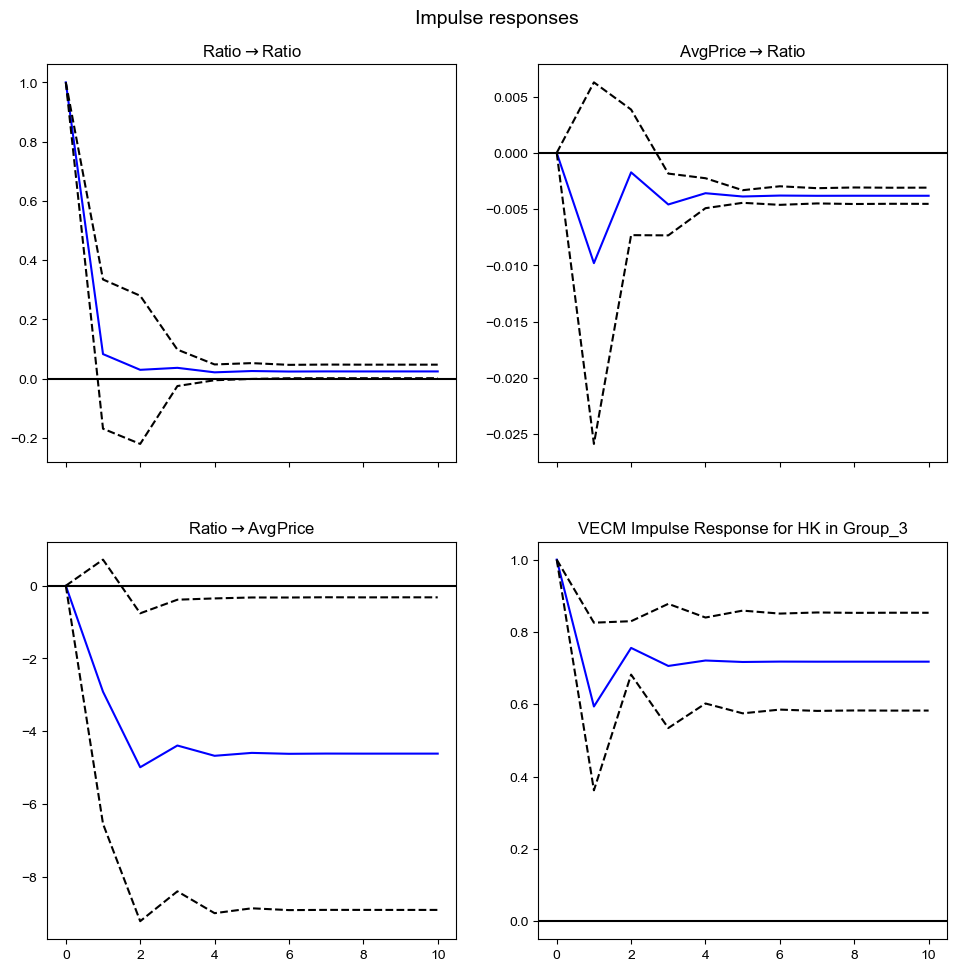


Cointegration exists for SH in Group_3.
Det. terms outside the coint. relation & lagged endog. parameters for equation Ratio
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
L1.Ratio        0.0712      0.163      0.436      0.663      -0.249       0.392
L1.AvgPrice     0.0147      0.012      1.247      0.212      -0.008       0.038
Det. terms outside the coint. relation & lagged endog. parameters for equation AvgPrice
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
L1.Ratio        0.6591      1.894      0.348      0.728      -3.052       4.371
L1.AvgPrice    -0.5417      0.137     -3.954      0.000      -0.810      -0.273
               Loading coefficients (alpha) for equation Ratio                
                 coef    std err          z      P>|z|      [0.025 

/Users/apple/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


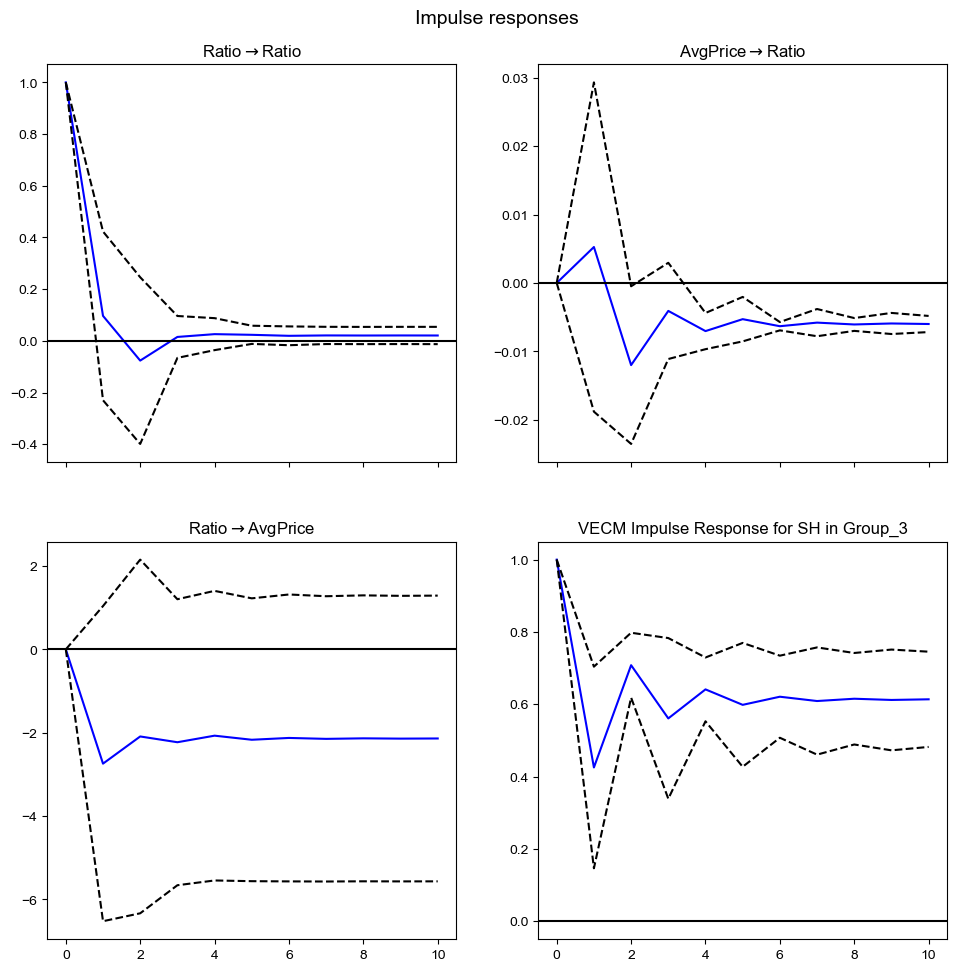

In [149]:
def vecm_analysis(groups):
    import matplotlib.pyplot as plt
    from statsmodels.tsa.vector_ar.vecm import VECM, coint_johansen
    
    for group_name, group_data in groups.items():
        print(f"\nGroup: {group_name}")
        for industry, df in group_data.items():
            
            df = df[['Ratio', 'AvgPrice']].dropna() 

            #test
            if df.shape[0] > 20:
                coint_test = coint_johansen(df, det_order=0, k_ar_diff=1)
                if any(coint_test.lr1 > coint_test.cvt[:, 1]):
                    print(f"\nCointegration exists for {industry} in {group_name}.")
                    model = VECM(df, coint_rank=1)
                    vecm_res = model.fit()

                    print(vecm_res.summary())

            
                    irf = vecm_res.irf(10)
                    irf.plot(orth=False)
                    plt.title(f'VECM Impulse Response for {industry} in {group_name}')
                    plt.show()
                else:
                    print(f"No cointegration found for {industry} in {group_name}.")
            else:
                print(f"Not enough data for {industry} in {group_name}.")

vecm_analysis(BJ_grouped_merged_data)



Processing Group_1

Processing Group_2

Processing Group_3


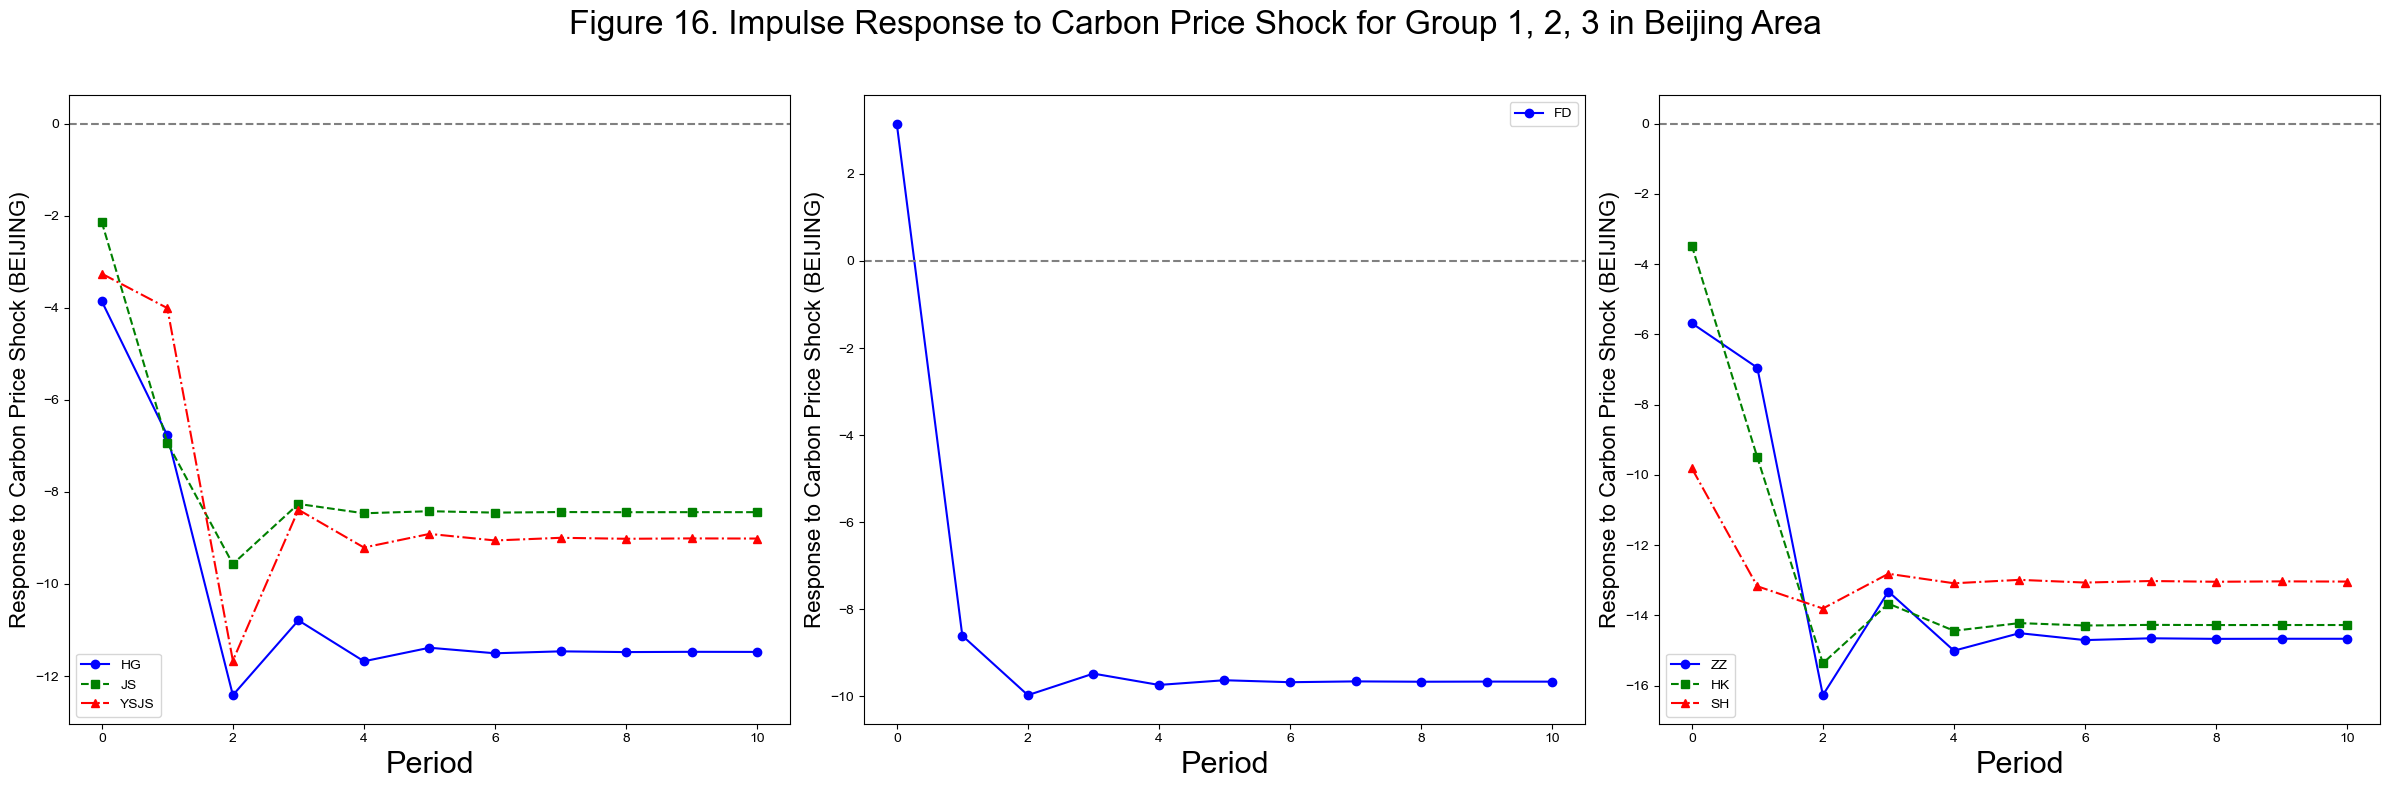

In [169]:
def plot_vecm_irf(groups, periods=10):
    markers = ['o', 's', '^', 'D', 'x', '*', 'p'] 
    lines = ['-', '--', '-.', ':', '-', '--', '-.']
    colors = ['b', 'g', 'r', 'c', 'm', 'y', 'k']  


    fig, axes = plt.subplots(1, 3, figsize=(24, 8))

    for idx, (group_name, group_data) in enumerate(groups.items()):
        ax = axes[idx]  
        print(f"\nProcessing {group_name}")
        
        for ind_idx, (industry, df) in enumerate(group_data.items()):
            if 'TradingDate' not in df.columns:
                # Assuming 'TradingDate' is already the index or properly set
                if isinstance(df.index, pd.PeriodIndex):
                    df.index = df.index.to_timestamp()  # Convert PeriodIndex to DatetimeIndex
                else:
                    df.index = pd.to_datetime(df.index)  # Ensure index is datetime
            else:
                df['TradingDate'] = pd.to_datetime(df['TradingDate'])
                df = df.drop_duplicates(subset='TradingDate')
                df.set_index('TradingDate', inplace=True)

            df.index = pd.DatetimeIndex(df.index).to_period('D')  # Set frequency to 'D'
            df = df[['Ratio', 'AvgPrice']].dropna()
            
            if df.empty or df.shape[0] < 2:
                print(f"Not enough data for {industry} in {group_name}")
                continue

            coint_test = coint_johansen(df, det_order=0, k_ar_diff=1)
            if any(coint_test.lr1 > coint_test.cvt[:, 1]):
                model = VECM(df, coint_rank=1)
                vecm_res = model.fit()

                irf = vecm_res.irf(periods)
                irf_values = irf.orth_irfs[:, 1, 0]  # Carbon price impact on stock prices

                ax.plot(range(periods + 1), irf_values, label=industry, 
                         marker=markers[ind_idx % len(markers)], 
                         linestyle=lines[ind_idx % len(lines)], 
                         color=colors[ind_idx % len(colors)])
            else:
                print(f"No cointegration found for {industry} in {group_name}")

        ax.axhline(y=0, color='gray', linestyle='--')
        ax.set_xlabel('Period', fontsize=22)
        ax.set_ylabel('Response to Carbon Price Shock (BEIJING)', fontsize=16)
        ax.legend(loc='best')

 
    plt.suptitle('Figure 16. Impulse Response to Carbon Price Shock for Group 1, 2, 3 in Beijing Area', fontsize=24)
    
    plt.tight_layout(rect=[0, 0, 1, 0.95])  
    plt.savefig('/Users/apple/Desktop/16Three_Group_VECM_IRF_BEIJING.png') 
    plt.show()
    plt.close()

plot_vecm_irf(BJ_grouped_merged_data)





Processing Group_1

Processing Group_2

Processing Group_3


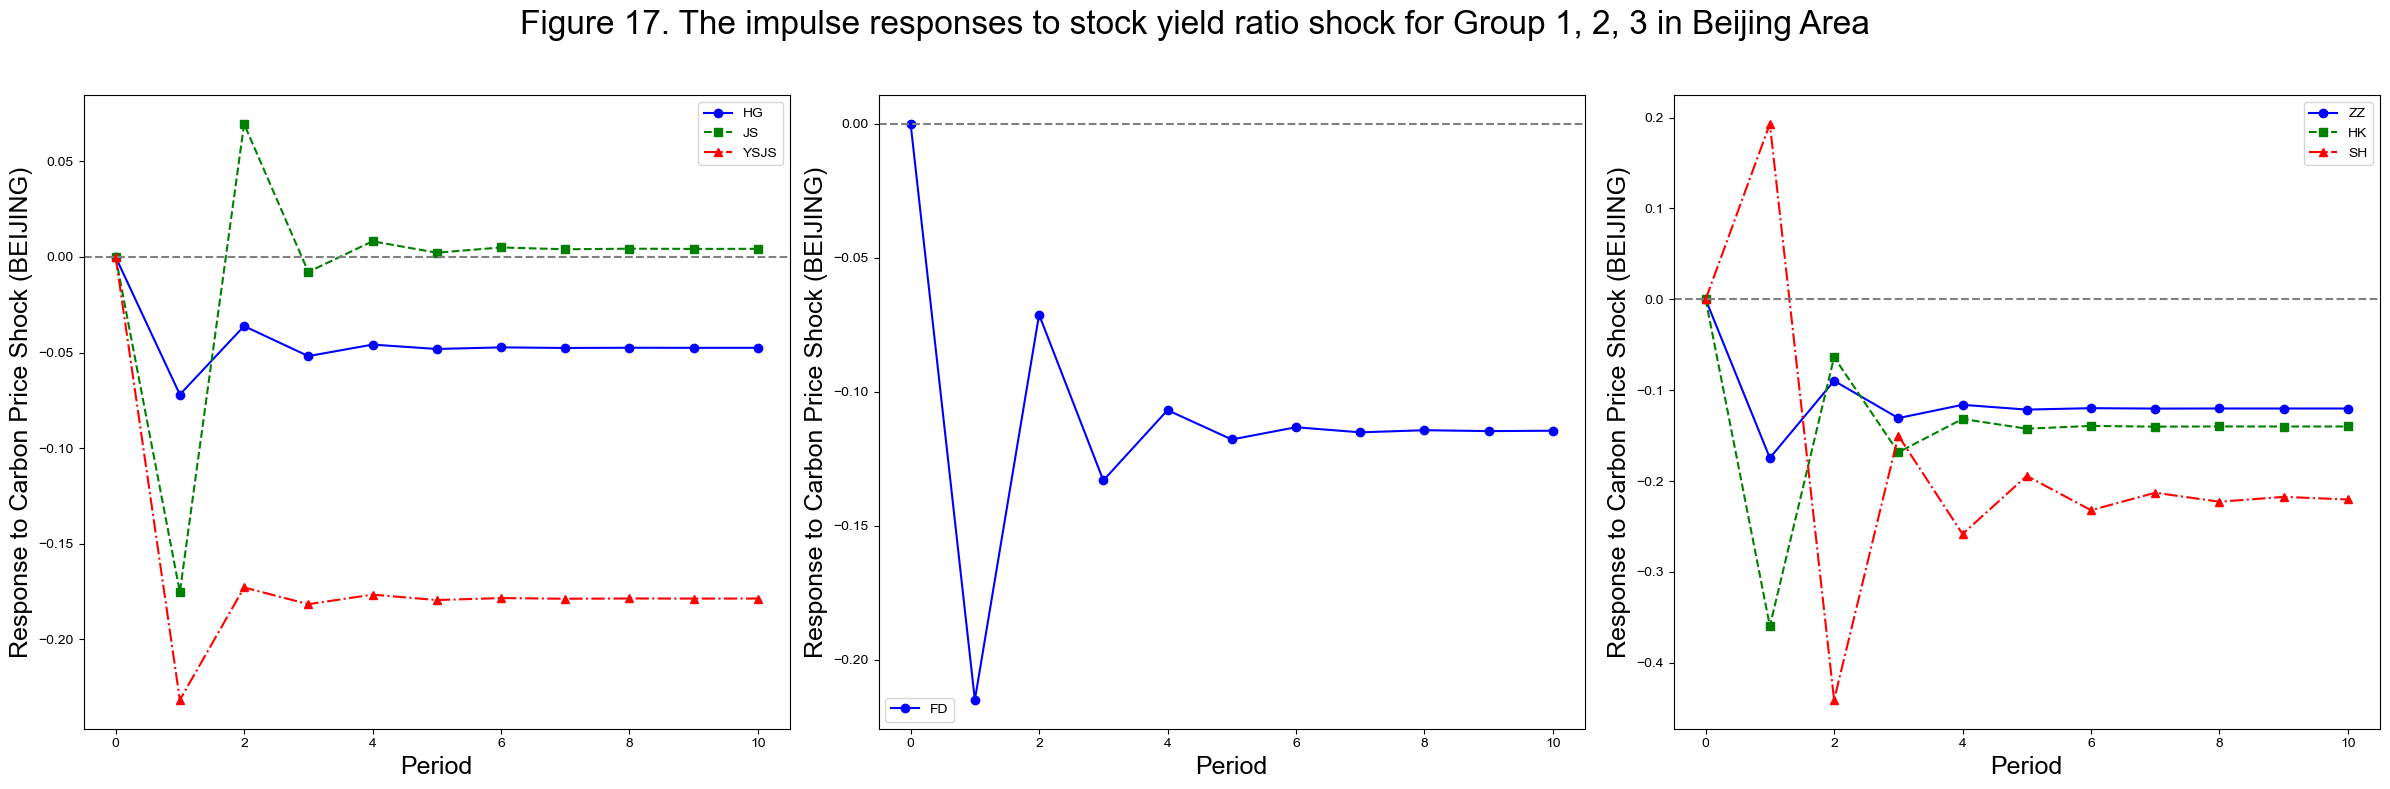

In [168]:
def plot_vecm_irf(groups, periods=10):
    markers = ['o', 's', '^', 'D', 'x', '*', 'p'] 
    lines = ['-', '--', '-.', ':', '-', '--', '-.'] 
    colors = ['b', 'g', 'r', 'c', 'm', 'y', 'k']  

    
    fig, axes = plt.subplots(1, 3, figsize=(24, 8))

    for idx, (group_name, group_data) in enumerate(groups.items()):
        ax = axes[idx] 
        print(f"\nProcessing {group_name}")
        
        for ind_idx, (industry, df) in enumerate(group_data.items()):
            if 'TradingDate' not in df.columns:
                # Assuming 'TradingDate' is already the index or properly set
                if isinstance(df.index, pd.PeriodIndex):
                    df.index = df.index.to_timestamp()  # Convert PeriodIndex to DatetimeIndex
                else:
                    df.index = pd.to_datetime(df.index)  # Ensure index is datetime
            else:
                df['TradingDate'] = pd.to_datetime(df['TradingDate'])
                df = df.drop_duplicates(subset='TradingDate')
                df.set_index('TradingDate', inplace=True)

            df.index = pd.DatetimeIndex(df.index).to_period('D')  # Set frequency to 'D'
            df = df[['Ratio', 'AvgPrice']].dropna()
            
            if df.empty or df.shape[0] < 2:
                print(f"Not enough data for {industry} in {group_name}")
                continue

            coint_test = coint_johansen(df, det_order=0, k_ar_diff=1)
            if any(coint_test.lr1 > coint_test.cvt[:, 1]):
                model = VECM(df, coint_rank=1)
                vecm_res = model.fit()

                irf = vecm_res.irf(periods)
                irf_values = irf.orth_irfs[:, 0, 1]  # Carbon price impact on stock prices

                ax.plot(range(periods + 1), irf_values, label=industry, 
                         marker=markers[ind_idx % len(markers)], 
                         linestyle=lines[ind_idx % len(lines)], 
                         color=colors[ind_idx % len(colors)])
            else:
                print(f"No cointegration found for {industry} in {group_name}")

        ax.axhline(y=0, color='gray', linestyle='--')
        ax.set_xlabel('Period', fontsize=18)
        ax.set_ylabel('Response to Carbon Price Shock (BEIJING)', fontsize=18)
        ax.legend(loc='best')


    plt.suptitle('Figure 17. The impulse responses to stock yield ratio shock for Group 1, 2, 3 in Beijing Area', fontsize=24)
    
    plt.tight_layout(rect=[0, 0, 1, 0.95]) 
    plt.savefig('/Users/apple/Desktop/17Three_Group_VECM_IRF_BEIJING.png') 
    plt.show()
    plt.close()


plot_vecm_irf(BJ_grouped_merged_data)